---

<center>
<h1>Pronóstico de la productividad forrajera y balance</h1>
<h1>hídrico en la región de los pastizales del Río de la Plata</h1>
</center>

---


<br>
<br>
<ul>
    <li>Bartol, Tomás Augusto</li>
    <li>Peiretti, Pablo </li>
    <li>Sánchez, Milagros Verónica </li>
</li>
</ul>


<br>
<h2>Abstract</h2>

This notebook was created with the purpose of introducing the use of multispectral satellite images as a tool for predicting forage production and water balance in the grasslands of the Río de la Plata. Based on this, the aim is to achieve a more efficient and precise management of resources. Additionally, there will be an attempt to increase livestock productivity by reducing variability in forage production. 

---

# Modules 

This section contains the import statements for external Python modules that are used throughout the notebook. This section is where external libraries or packages are loaded in order to provide additional functionality beyond the basic Python capabilities


In [4]:
### Load the imports ### 
import numpy as np
import pandas as pd
import geopandas as gpd
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.layers import Input, Dense, LSTM
from matplotlib import pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates
import folium
from branca.colormap import linear
from IPython.display import display
from folium import plugins
from shapely.geometry import Polygon
from shapely.geometry import MultiPoint, MultiPolygon
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
import ipywidgets as widgets
from IPython.display import display


--- 

# Utilities

The Utilities Section in this Jupyter Notebook serves as a collection of tools and auxiliary functions designed to streamline common tasks, enhance code efficiency, and provide reusable functionalities.

In [5]:
""" 
We need a few utilities to simplify object-oriented programming in Jupyter notebooks. One
of the challenges is that class definitions tend to be fairly long blocks of code. Notebook
readability demands short code fragments, interspersed with explanations, a requirement
incompatible with the style of programming common for Python libraries. The first utility
function allows us to register functions as methods in a class after the class has been created.
""" 

class Utils:
    
    
    #Register functions as methods in created class.
    @staticmethod
    def add_method_to_class(Class): #@save

        def wrapper(obj):
            setattr(Class, obj.__name__, obj)
        
        return wrapper
    
    @staticmethod    
    def plot_training_history(fig, history, metric):

        validation_metric = f"val_{metric}"

        fig.plot(history.history[metric], label=f"Training {metric}")
        fig.plot(history.history[validation_metric], label=f"Validation {metric}")
        fig.set_xlabel("Epoch")
        fig.set_ylabel(f"{metric}")
        fig.legend()

        merged_mae_lists = history.history[f"{metric}"][0:] + history.history[f"val_{metric}"][0:]
        highest_loss = max(merged_mae_lists)
        lowest_loss = min(merged_mae_lists)
        delta = highest_loss - lowest_loss
        top_of_y_axis = highest_loss + (delta * 0.05)
        bottom_of_y_axis = lowest_loss - (delta * 0.05)

        fig.set_ylim([bottom_of_y_axis, top_of_y_axis])

    @staticmethod
    def plot_result_in_fixed_position(ax, longitude, latitude, index, model): 
        test_sequence_fixed_position_df = DataManager(test_df[(test_df['longitude'] == longitude) & (test_df['latitude'] == latitude)])
        test_sequence_fixed_position, test_labels_fixed_position = test_sequence_fixed_position_df.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
        predict = model.predict(test_sequence_fixed_position, verbose=0)
        ax.plot(test_sequence_fixed_position[index,:, -1], label='Input data')
        ax.plot(range(INPUT_STEPS , OUTPUT_STEPS  + INPUT_STEPS), predict[index], label="Model predictions")
        ax.plot(range(INPUT_STEPS , OUTPUT_STEPS  + INPUT_STEPS), test_labels_fixed_position[index], label="Data labels")
        ax.set_xlabel("fortnight")  
        ax.set_ylabel("Normalized PPNA") 
        ax.set_title(f"Prediction for location ['{longitude}','{latitude}']")
        ax.legend()




--- 

# Macros 

The Globals and Macros section in this codebase serves as a centralized hub for managing global variables and macros that impact the entire project. This section is dedicated to storing constants, configuration parameters, and reusable macros that streamline the development process and ensure consistency across various components.

In [6]:
DATABASE_PATH = "Database\database.csv"
SAMPLES_PER_LOCATION = 460
COLORS = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', \
     'lightred', 'darkblue', 'darkgreen', 'cadetblue', \
     'darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray', \
     'black', 'lightgray', 'red', 'blue', 'green', 'purple', \
     'orange', 'darkred', 'lightred', 'beige', 'darkblue', \
     'darkgreen', 'cadetblue', 'darkpurple','pink', 'lightblue', \
     'lightgreen', 'gray', 'black', 'lightgray', 'beige' ]
CLUSTERS_QTY = 16

---

# Data

In this dedicated segment, our primary emphasis will be on the comprehensive visualization and skillful manipulation of the data provided by the MODIS remote sensor. We will delve into the intricacies of presenting the information in a visually impactful manner, ensuring that we not only harness the power of visualization techniques but also adeptly navigate the nuances of manipulating the MODIS dataset for meaningful insights.

In [77]:
"""
Class that manage data and provides methods to visualize it. 
"""

class DataManager(pd.DataFrame):
    
    def load_data(self, filepath):
        try:
            # Load data into the DataFrame itself
            self.__init__(pd.read_csv(filepath))
            self['date'] = pd.to_datetime(self['date'])
            print(f"Data loaded successfully from {filepath}")
        except Exception as e:
            print(f"Error loading data: {e}")

    def date_to_timestamp(self): 
        
        self['timestamp_date'] = pd.to_datetime(self['date'], format='%m/%d/%Y').map(pd.Timestamp.timestamp)

    def show_correlation(self,fig, var1, var2): 

        fig.scatter(self[f"{var1}"], self[f"{var2}"], c='blue', alpha=0.7, s=5)
        r=correlation = self[f"{var1}"].corr(self[f"{var2}"])
        r=round(r,3)
        fig.set_title(f"Correlation between {var1} and {var2} (R = {r})")
        fig.set_xlabel(f'{var1}'.upper())
        fig.set_ylabel(f'{var2}'.upper())
        fig.grid(True)

    def show_ppna_fixed_position (self, fig, latitude, longitude):

        fix_position_df = self[(self['longitude'] == longitude) & (self['latitude'] == latitude)].copy()
        fix_position_df['date'] = pd.to_datetime(fix_position_df['date'])
        fig.plot(fix_position_df['date'], fix_position_df['ppna'], c='blue')
        fig.set_title("PPNA over time in fixed location")
        fig.set_xlabel('Date')
        fig.set_ylabel('PPNA')
        fig.grid(True)

    def show_ppna_year_comparision_fixed_position(self, fig, year1, year2, latitude, longitude): 
        
        fix_position_df = self[(self['longitude'] == longitude) & (self['latitude'] == latitude)].copy()
        fix_position_df['date'] = pd.to_datetime(fix_position_df['date'])

        for year in fix_position_df['date'].dt.year.unique():
            if year == year1 or year == year2:
                year_data = fix_position_df[fix_position_df['date'].dt.year == year]
                dias_meses = [fecha.strftime('%d-%m') for fecha in year_data['date']]
                fig.plot(dias_meses, year_data['ppna'], label=f'Year {year}')

        # Adjusting the x-axis labels for better readability
        fig.tick_params(axis='x', rotation=45)
        fig.set_title("PPNA Comparison over the years")
        fig.set_xlabel('Date')
        fig.set_ylabel('PPNA')
        fig.legend()
        fig.grid(True)

    def show_heat_map(self):

        # Crear un mapa centrado en la ubicación media de tus datos
        mapa = folium.Map(location=[self['latitude'].mean(), self['longitude'].mean()], zoom_start=6)

        # Creo un df con fecha, latitude, longitud y valor de la ppna 
        ppna_heatmaptime_df = self[['date','latitude','longitude','ppna']]
        ppna_heatmaptime_df['date'] = ppna_heatmaptime_df['date'].sort_values(ascending=True)
        data = []
        for _, d in ppna_heatmaptime_df.groupby('date'):
            data.append([[row['latitude'], row['longitude'], row['ppna']] for _, row in d.iterrows()])
        data

        #creo el indice de tiempo para graficar en el mapa 
        time_index = list(ppna_heatmaptime_df['date'].astype('str').unique())


        plugins.HeatMapWithTime(data,
                        index=time_index,
                        auto_play=True,
                        radius=10,
                        use_local_extrema=True
                    ).add_to(mapa)


        # Agrego labels
        """
        Lo dejo comentado por que por performance tarda mucho, despues vemos si lo necesitamos como solucionarlo 
        percentage_to_label = 5  # Porcentaje de puntos para los que se agregarán etiquetas
        total_points = sum(len(points) for points in data)
        points_to_label = [point for points in data for point in points if hash(tuple(point)) % 100 < percentage_to_label]

        for lat, lon, value in points_to_label:
            label = value
            folium.Marker(location=[lat, lon], popup=label).add_to(mapa)

        """

        display(mapa)

    def normalize_data(self):
        mean = self.mean()
        std = self.std()
        self[['ppna', 'ppt', 'temp']] = (self[['ppna', 'ppt', 'temp']] - mean[['ppna', 'ppt', 'temp']]) / std[['ppna', 'ppt', 'temp']]


    def denormalize_data(self):
        mean = self.mean()
        std = self.std()
        self[['ppna', 'ppt', 'temp']] = self[['ppna', 'ppt', 'temp']] * std[['ppna', 'ppt', 'temp']] + mean[['ppna', 'ppt', 'temp']]


In [7]:
ppna_df = DataManager()
ppna_df.load_data(DATABASE_PATH) 
ppna_df.info()

Data loaded successfully from Database\database.csv
<class '__main__.DataManager'>
RangeIndex: 690000 entries, 0 to 689999
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         690000 non-null  int64         
 1   date       690000 non-null  datetime64[ns]
 2   longitude  690000 non-null  float64       
 3   latitude   690000 non-null  float64       
 4   ppna       690000 non-null  float64       
 5   ppt        690000 non-null  float64       
 6   temp       690000 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 36.9 MB



## Data Visualization 


In [8]:
ppna_df.head()

,id,date,longitude,latitude,ppna,ppt,temp
0,0,2001-01-01,-56.83242,-31.544792,405.340618,76.155505,24.333897
1,1,2001-01-17,-56.83242,-31.544792,362.433361,91.647396,23.921929
2,2,2001-02-02,-56.83242,-31.544792,420.441046,80.999538,24.132180
3,3,2001-02-18,-56.83242,-31.544792,335.261458,88.673292,26.170466
4,4,2001-03-06,-56.83242,-31.544792,301.399079,5.496469,24.043910


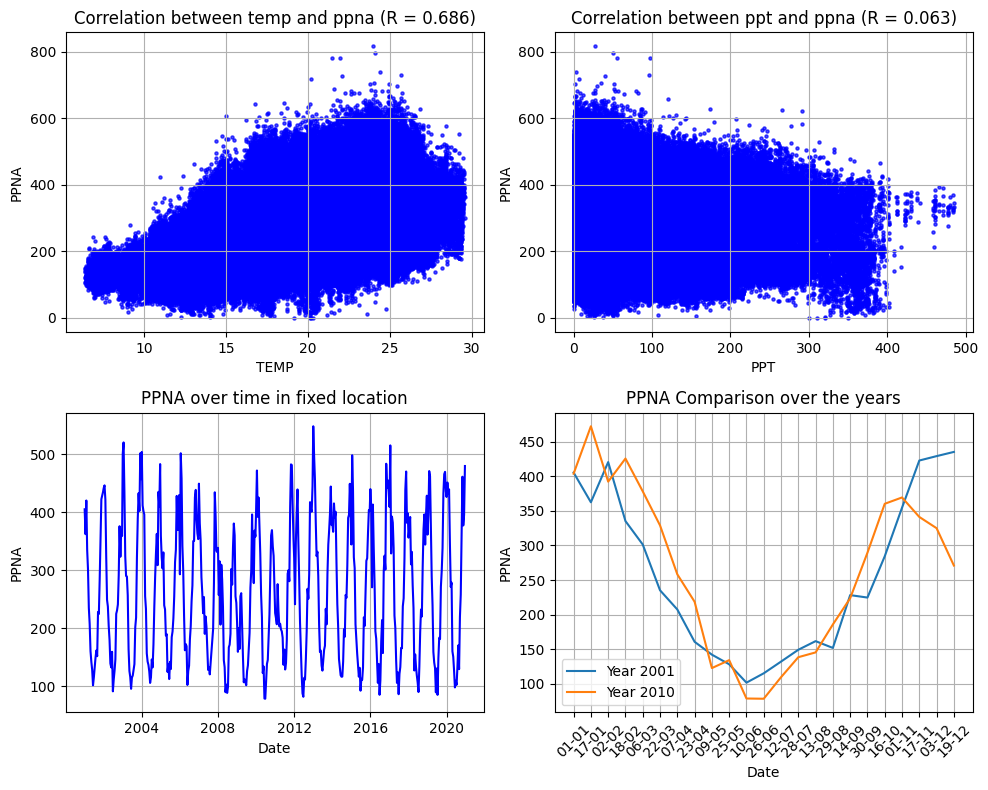

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
pd.options.mode.chained_assignment = None

ppna_df.show_correlation(axes[0,0], 'temp', 'ppna')
ppna_df.show_correlation(axes[0,1], 'ppt', 'ppna')
ppna_df.show_ppna_fixed_position(axes[1,0], ppna_df['latitude'][100], ppna_df['longitude'][100])
ppna_df.show_ppna_year_comparision_fixed_position(axes[1,1], 2001, 2010, ppna_df['latitude'][0], ppna_df['longitude'][0])

fig.tight_layout()
plt.show()

## Data Managment

In [10]:
"""
Convert from date to timestamp format
""" 
ppna_df.date_to_timestamp()

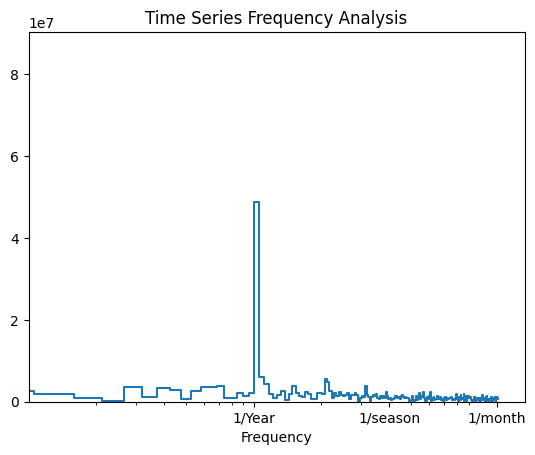

In [11]:
"""
Temporal periodicity analysis of our data set, where it can be seen that it has a very important annual periodicity.
"""

# group dataframe by date 
combined_series = ppna_df.groupby(['date'])['ppna'].sum().sort_index()


# Apply FFT
fft = tf.signal.rfft(combined_series)
f_per_dataset = np.arange(0, len(fft))


n_samples_h = len(combined_series)
f_sample = 15 #1 sample every 15 days 
years_per_dataset = n_samples_h * f_sample / 365  #number of samples * frecuency sample day * num of days in a year give me the number of years 
f_per_year = f_per_dataset / years_per_dataset

# Grafica la amplitud de las frecuencias en una escala de logaritmo.
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, max( np.abs(fft) /2))
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 4, 12], labels=['1/Year', '1/season', '1/month'])
plt.title('Time Series Frequency Analysis' )
plt.xlabel('Frequency')
plt.show()

Text(0.5, 1.0, 'Time signal')

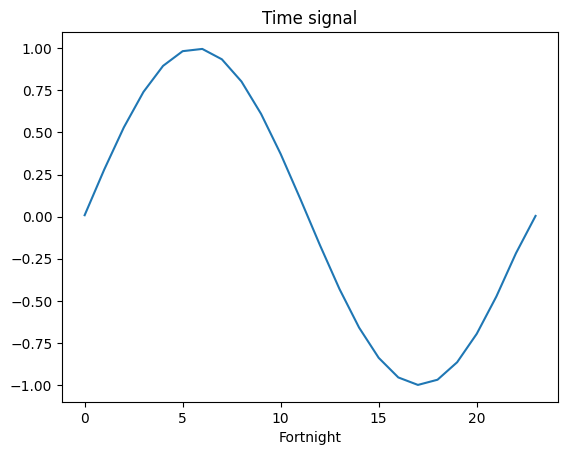

In [12]:
"""
Time in seconds is not a useful input for the model. Being meteorological data, it exhibits clear daily and annual periodicity. There are many ways to deal with this periodicity.
You can obtain usable signals by using sine and cosine transformations to remove the "Time of day" and "Time of year" signals.
As we previously analyzed, the most important time dependence is annual, therefore, we will use a time signal with an annual period.
"""
day = 24*60*60
year = (365.2425)*day


ppna_df['date_signal'] = np.sin(ppna_df['timestamp_date'] * (2 * np.pi / year))

plt.plot(np.array(ppna_df['date_signal'])[:24]) #veinticinco muestras son casi un año (15 * 24 = 360 dias) y vemos ue se cumple un periodo de la señal temporal
plt.xlabel('Fortnight')
plt.title('Time signal')



In [11]:
"""
Divide the dataframe into three sections (train, test, validation) with roughly a 70-20-10 distribution. 
As we have 20 years of data, it is going to be diveded into 14 years, 4 years and 2 years (70%,20% and 10%).
The samples are divided secuentially to improve the RNN performance.
"""

#ppna_df =  ppna_df[(ppna_df['longitude'] == ppna_df['longitude'][100]) & (ppna_df['latitude'] == ppna_df['latitude'][100])].copy() #-> lo hago para una sola ubicacion, despues hay que ver como cambiar esto 
train_df = DataManager(ppna_df[ppna_df['date'] < '2014-01-01'][[ 'date_signal', 'latitude', 'longitude', 'ppt','temp', 'ppna']])
val_df =  DataManager(ppna_df[(ppna_df['date'] >= '2014-01-01') & (ppna_df['date'] < '2019-01-01')][[ 'date_signal', 'latitude', 'longitude', 'ppt', 'temp', 'ppna']])
test_df = DataManager(ppna_df[ppna_df['date'] >= '2019-01-01'][['date_signal', 'latitude', 'longitude', 'ppt','temp', 'ppna']])

In [12]:
"""
Normalization of every dataframe. The chosen normalization uses mean and standard deviation
Every Dataframe must be normalized by the same values, hence the train df mean and deviation are saved

(También es discutible que el modelo no debería tener acceso a valores futuros en el conjunto de entrenamiento 
durante el entrenamiento, y que esta normalización debería hacerse usando promedios móviles. Ese no es el enfoque 
de este tutorial, y los conjuntos de validación y prueba aseguran que obtenga métricas (algo) honestas. 
Entonces, en aras de la simplicidad, este tutorial usa un promedio simple.) 

https://medium.com/@spinjosovsky/normalize-data-before-or-after-split-of-training-and-testing-data-7b8005f81e26
https://datascience.stackexchange.com/questions/27615/should-we-apply-normalization-to-test-data-as-well
"""
train_df.normalize_data()
val_df.normalize_data()
test_df.normalize_data()

### Data Window

We first need to prepare the data to be fed into an LSTM. The LSTM model learns a function that maps a sequence of past observations as input to an output observation. As such, the sequence of observations must be transformed into multiple examples from which the LSTM can learn.

To make it concrete in terms of the speed prediction problem, we choose to use 1 year of historical observations to predict the future, lets say, 15 days ahead. Hence, we would first reshape the timeseries data into windows of 24 historical observations for each segment as the input and the speed 15 days later is the label we are interested in predicting. We use the sliding window approach to prepare the data. This is how it works:

Starting from the beginning of the timeseries, we take the first 24 records as the 24 input features and the speed 1 timesteps head (15 days) as the ppna we want to predict.

Shift the timeseries by one timestep and take the 24 observations from the current point as the input features and the speed 15 days ahead as the output to predict.

Keep shifting by 1 timestep and picking the 24 timestep window from the current time as input feature and the speed one hour ahead of the 10th timestep as the output to predict, for the entire data.

The above steps are done for latitude and longitude. 

The function below returns the above transformed timeseries data for the model to train on. The parameter seq_len is the size of the past window of information. The pre_len is how far in the future does the model need to learn to predict.

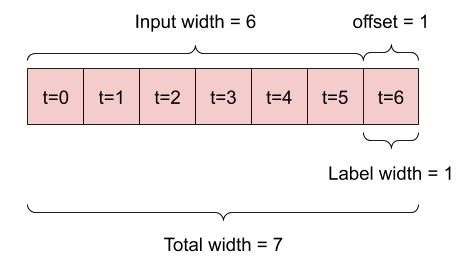

In [102]:
"""
This function is main in a LSTM model, prepare the data in form of past observations and future lable. For example, if the data is [1,2,3,4,5,6,7,8,9,10], the seq_len = 5 and the pre_len = 1: 
past_data = [[1],[2],[3],[4],[5]] , label data = [6]
past_data = [[2],[3],[4],[5],[6]] , label data = [7]
and so on...
"""

# Apply decorator to add the sequence data preparation to DataManager class 
@Utils.add_method_to_class(DataManager)
def sequence_data_preparation(self, seq_len, pre_len):

    past_data = []  # Window for the past 
    label_data = []  # Predict next value 

    for i in range(self.shape[0] - int(seq_len + pre_len - 1)):
        a = self[i: i + seq_len + pre_len] 
        past_data.append(a[:seq_len])
        label_data.append(a[-pre_len:]['ppna'])

    past_data = np.array(past_data)
    label_data = np.array(label_data)

    return past_data, label_data


--- 

# Recurrent Neuronal Network

In this section, we delve into the examination and analysis of various topologies within recurrent neural networks (RNNs) with the primary goal of estimating and predicting the productivity of forage production. Forage production, a critical aspect of agricultural ecosystems, can be influenced by a multitude of factors, and leveraging the capabilities of RNNs allows us to capture the temporal dependencies inherent in such dynamic systems.

## LSTM - Multivariable 

We will embark on the construction of a Long Short-Term Memory (LSTM) neural network tailored for the PPNA. Leveraging the power of LSTM architecture, we aim to develop a robust model capable of capturing temporal dependencies within the data, ultimately enhancing our ability to forecast PPNA trends. Throughout this endeavor, we will explore the intricacies of LSTM networks, fine-tune model parameters, and implement effective training strategies to optimize predictive accuracy.

A recurrent model can learn to use a long history of inputs if it is relevant for the predictions the model makes. 
Here, the model will accumulate internal state over a year (24 samples) before making a single prediction for the next 15 days (1 sample).

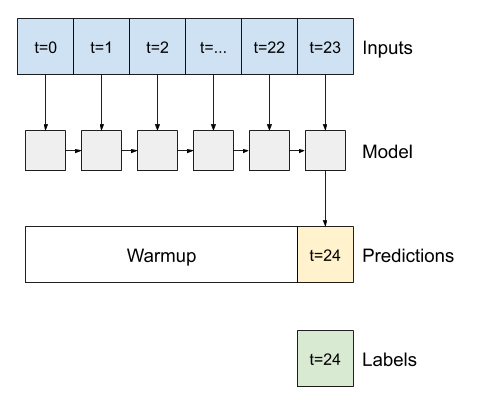

In [14]:
INPUT_STEPS = 24 #1 Year
OUTPUT_STEPS = 12 #15 DAYS
train_sequence, train_labels = train_df.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
val_sequence, val_labels = val_df.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
test_sequence, test_labels = test_df.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
print("train sequence: (num train data, past_data, features) ->", test_sequence.shape)
print("label sequence: (num train data, output_steps) -> ", test_labels.shape)

train sequence: (num train data, past_data, features) -> (68965, 24, 6)
label sequence: (num train data, output_steps) ->  (68965, 12)


In [15]:
"""
Neuronal Network Model for LSTM one shot 
"""

LEARNING_RATE = 0.000003

model_one_shot = tf.keras.Sequential()

model_one_shot.add(Input((INPUT_STEPS, train_df.shape[1])))

model_one_shot.add(LSTM(128))

model_one_shot.add(Dense(32,'relu'))

model_one_shot.add(Dense(OUTPUT_STEPS * 1,'linear'))

model_one_shot.summary()

model_one_shot.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate=LEARNING_RATE),
                metrics=[tf.metrics.RootMeanSquaredError()])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='root_mean_squared_error',
                                                patience=2,
                                                mode='min')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               69120     
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 12)                396       
                                                                 
Total params: 73644 (287.67 KB)
Trainable params: 73644 (287.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
"""
The .fit method is a crucial step in the machine learning workflow, where a model learns patterns and relationships 
from a training dataset. During the training process, the model adjusts its internal parameters based on the input 
data and corresponding target values. The goal is to minimize the difference between the model's predictions and the
 actual target values. The training process involves iteratively updating the model parameters through techniques like 
 gradient descent or other optimization algorithms.
"""

EPOCHS = 5
history = model_one_shot.fit(train_sequence, train_labels, validation_data=(val_sequence,val_labels), epochs=EPOCHS, batch_size=32, callbacks=[early_stopping])

Epoch 1/5

14015/14015 [==============================] - 216s 15ms/step - loss: 0.8324 - root_mean_squared_error: 0.9123 - val_loss: 0.3691 - val_root_mean_squared_error: 0.6076
Epoch 2/5
14015/14015 [==============================] - 234s 17ms/step - loss: 0.3061 - root_mean_squared_error: 0.5533 - val_loss: 0.2265 - val_root_mean_squared_error: 0.4759
Epoch 3/5
14015/14015 [==============================] - 219s 16ms/step - loss: 0.2585 - root_mean_squared_error: 0.5084 - val_loss: 0.2182 - val_root_mean_squared_error: 0.4671
Epoch 4/5
14015/14015 [==============================] - 361s 26ms/step - loss: 0.2467 - root_mean_squared_error: 0.4967 - val_loss: 0.2196 - val_root_mean_squared_error: 0.4686
Epoch 5/5
14015/14015 [==============================] - 469s 33ms/step - loss: 0.2390 - root_mean_squared_error: 0.4889 - val_loss: 0.2205 - val_root_mean_squared_error: 0.4696


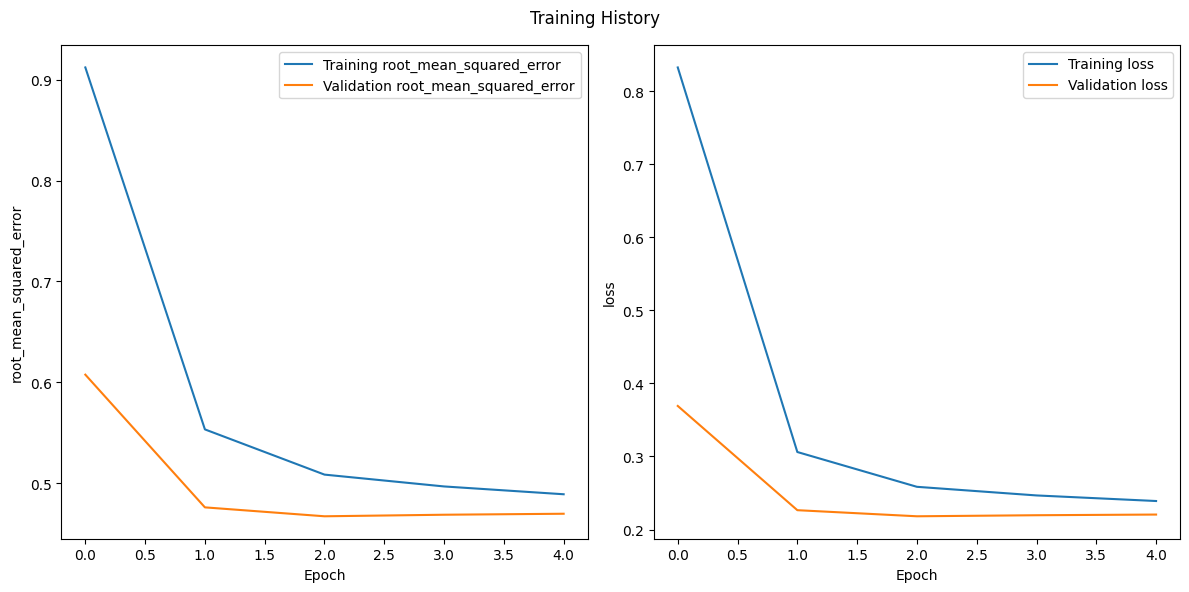

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
pd.options.mode.chained_assignment = None


# plot training history
Utils.plot_training_history(axes[0], history, "root_mean_squared_error")
Utils.plot_training_history(axes[1], history, "loss")

# Mostrar el gráfico
fig.suptitle("Training History")
fig.tight_layout()
plt.show()


In [18]:
"""
Evaluate the model over the validation data, if the metrics are not good, change the model an test again
"""
metric = model_one_shot.evaluate(val_sequence, val_labels)

print("The values of Loss and Root Mean Squared Error are: ", metric)

  17/5390 [..............................] - ETA: 1:23 - loss: 0.2060 - root_mean_squared_error: 0.4539

5390/5390 [==============================] - 69s 13ms/step - loss: 0.2205 - root_mean_squared_error: 0.4696
The values of Loss and Root Mean Squared Error are:  [0.2205100655555725, 0.4695851504802704]


In [63]:
index_slider = widgets.IntSlider(min=0, max=OUTPUT_STEPS-2 , step=1, value=0, description='Fortnight:', layout=widgets.Layout(width='60%', margin='0px 0px 0px 0px'))

def update_plot(index):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    fig.suptitle('Model Resuts')
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)
    Utils.plot_result_in_fixed_position(axes[0,0],ppna_df['longitude'][400000], ppna_df['latitude'][400000],index, model_one_shot)
    Utils.plot_result_in_fixed_position(axes[0,1],ppna_df['longitude'][0], ppna_df['latitude'][0],index, model_one_shot)
    Utils.plot_result_in_fixed_position(axes[1,0],ppna_df['longitude'][10000], ppna_df['latitude'][10000],index, model_one_shot)
    Utils.plot_result_in_fixed_position(axes[1,1],ppna_df['longitude'][30000], ppna_df['latitude'][30000],index,  model_one_shot)
    


widgets.interactive(update_plot, index=index_slider)


TraitError: setting max < min

## CONV LSTM - Multivariable 

In [20]:
#[samples, timesteps, rows, cols, channels]
#train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
train_x =  train_sequence.reshape((train_sequence.shape[0], 2, 1, 12, 6))
val_x = val_sequence.reshape((val_sequence.shape[0],2,1,12,6))
test_x =  test_sequence.reshape((test_sequence.shape[0], 2, 1, 12, 6))
print("(samples, timesteps, rows, cols, channels) ->", train_x.shape)

(samples, timesteps, rows, cols, channels) -> (448465, 2, 1, 12, 6)


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Flatten, RepeatVector, LSTM, TimeDistributed, Dense

model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(2, 1, 12, 6)))
model.add(Flatten())
model.add(RepeatVector(12))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mse', optimizer='adam')

In [22]:
model.fit(train_x, train_labels,validation_data=(val_x,val_labels), epochs=3, batch_size=32, verbose=1)

Epoch 1/3
14015/14015 [==============================] - 645s 46ms/step - loss: 0.1515 - val_loss: 0.2518
Epoch 2/3
14015/14015 [==============================] - 596s 43ms/step - loss: 0.0896 - val_loss: 0.2855
Epoch 3/3
14015/14015 [==============================] - 600s 43ms/step - loss: 0.0797 - val_loss: 0.3084


In [23]:
result_x = model.predict(test_x)

2156/2156 [==============================] - 22s 10ms/step


1/1 [==============================] - 0s 33ms/step


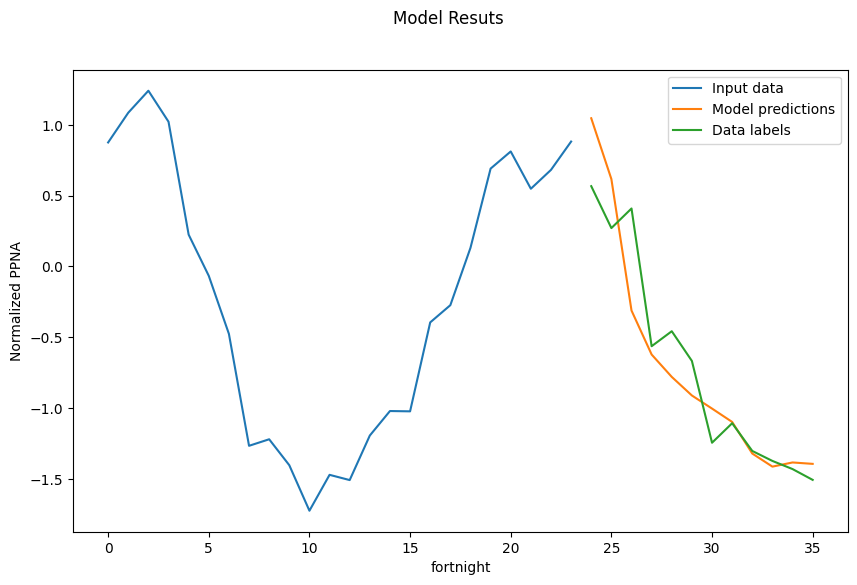

In [24]:
test_sequence_fixed_position_df = DataManager(test_df[(test_df['longitude'] == ppna_df['longitude'][11100]) & (test_df['latitude'] == ppna_df['latitude'][11100])])
test_sequence_fixed_position, test_labels_fixed_position = test_sequence_fixed_position_df.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
test_x = test_sequence_fixed_position.reshape((test_sequence_fixed_position.shape[0], 2, 1, 12, 6))
predict = model.predict(test_x)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
fig.suptitle('Model Resuts')

ax.plot(test_sequence_fixed_position[0,:, -1], label='Input data')
ax.plot(range(INPUT_STEPS , OUTPUT_STEPS  + INPUT_STEPS), predict[0], label="Model predictions")
ax.plot(range(INPUT_STEPS , OUTPUT_STEPS  + INPUT_STEPS), test_labels_fixed_position[0], label="Data labels")
ax.set_xlabel("fortnight")  
ax.set_ylabel("Normalized PPNA") 
ax.legend()



### Tests for efficient data clustering

https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad
https://www.analyticsvidhya.com/blog/2021/01/in-depth-intuition-of-k-means-clustering-algorithm-in-machine-learning/

###### NOTA: debatir si sacar PPNA como metodo de clustering porque despues no se va a poder usar

In [8]:
ppna_df_feature_cross = DataManager()
ppna_df_feature_cross.load_data(DATABASE_PATH) 
ppna_df_feature_cross.info()

Data loaded successfully from Database\database.csv
<class '__main__.DataManager'>
RangeIndex: 690000 entries, 0 to 689999
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         690000 non-null  int64         
 1   date       690000 non-null  datetime64[ns]
 2   longitude  690000 non-null  float64       
 3   latitude   690000 non-null  float64       
 4   ppna       690000 non-null  float64       
 5   ppt        690000 non-null  float64       
 6   temp       690000 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 36.9 MB


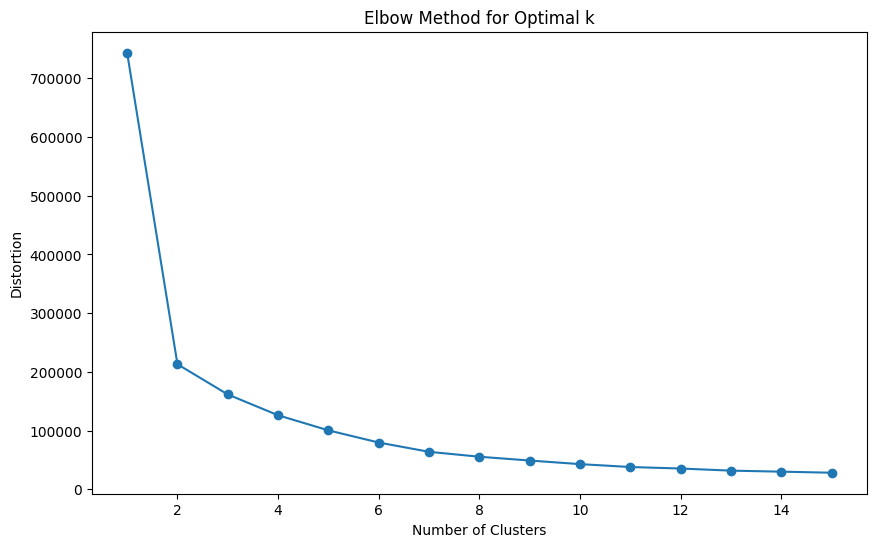

In [26]:
'''
Elbow method to determine the most efficient number of centroids. The optimal value will be that 
in which the function plot "bends" and "forms an elbow"
'''

def elbow_method(data, max_clusters=10):
    X = data[['latitude', 'longitude']]

    distortions = []
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
        kmeans.fit(X)
        distortions.append(kmeans.inertia_)


    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters + 1), distortions, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion')
    plt.show()


elbow_method(ppna_df_feature_cross, 15)


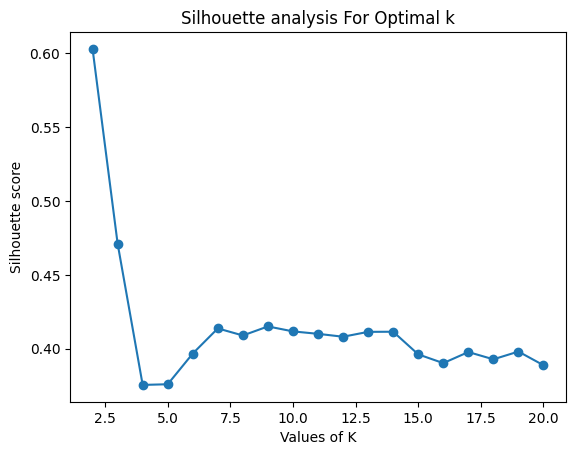

In [27]:
'''
Average Silhouette method to determine the most efficient number of centroids. The optimal value will be that for which the 
silhouette score is closer to 1, indicating that every datapoint is near the centroid and the clusters are more compact.
The method is not 100% efficient as the dataset must be shortened to one sample per location because of computing limitations
'''


def silhouette_method(dataset, max_clusters):
 
    k_values = range(2, max_clusters + 1)
    silhouette_scores = []

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init = 10)
        cluster_labels = kmeans.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    plt.plot(k_values, silhouette_scores, marker='o')
    plt.xlabel('Values of K') 
    plt.ylabel('Silhouette score') 
    plt.title('Silhouette analysis For Optimal k')
    plt.show()

   
    optimal_k = k_values[np.argmax(silhouette_scores)]
    return optimal_k

counter = 0
X = []
for _, row in ppna_df_feature_cross.iterrows():

    if counter % SAMPLES_PER_LOCATION == 0:
        X.append([row["latitude"], row["longitude"]])
    
    counter += 1
    
optimal_k = silhouette_method(X, 20)


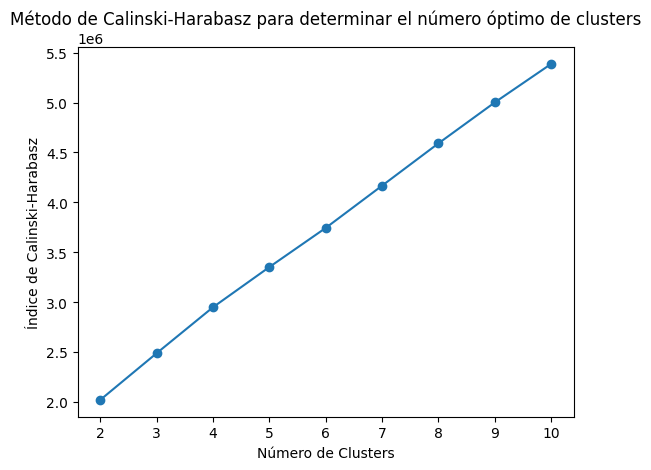

In [28]:
'''
Calinski-Harabasz method to determine the most efficient number of centroids. The optimal value will be that for which the 
index is higher, indicating that the clusters are more separated and defined.

https://www.geeksforgeeks.org/calinski-harabasz-index-cluster-validity-indices-set-3/
'''

def calinski_harabasz_method(X, max_clusters):
    scores = []
    
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        score = calinski_harabasz_score(X, kmeans.labels_)
        scores.append(score)
    
    plt.plot(range(2, max_clusters + 1), scores, marker='o')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Índice de Calinski-Harabasz')
    plt.title('Método de Calinski-Harabasz para determinar el número óptimo de clusters')
    plt.show()


X = ppna_df_feature_cross[['latitude', 'longitude', 'ppna']]
calinski_harabasz_method(X, 10)




In [16]:
#Otro metodo de calinski-Harabasz para chequear

from yellowbrick.cluster import KElbowVisualizer
model = KMeans(n_init=10)
X = ppna_df_feature_cross[['latitude', 'longitude', 'ppna']]
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30),metric='calinski_harabasz', timings= True)
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()

ModuleNotFoundError: No module named 'yellowbrick'

### Data Clustering

This section shows the algorhitms used to categorize each value into a cluster. It also provides several maps to show the geographical caracteristics of the dataset

https://journals.openedition.org/cybergeo/27035 (Para justificar uso de K-means de geometria euclidea)
https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/ (Buena info de como funciona el clustering)

In [12]:

X = ppna_df_feature_cross[['latitude', 'longitude']]
kmeans = KMeans(
    #init="random",
    init='k-means++',
    n_clusters=CLUSTERS_QTY,
    n_init=10,
    max_iter=300,
    random_state=42
).fit(X)

labels = kmeans.labels_
X['cluster'] = labels



C:\Users\Michi\AppData\Local\Temp\ipykernel_21676\2901380595.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cluster'] = labels


In [13]:
X.info()
kmeans.labels_

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690000 entries, 0 to 689999
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   latitude   690000 non-null  float64
 1   longitude  690000 non-null  float64
 2   cluster    690000 non-null  int32  
dtypes: float64(2), int32(1)
memory usage: 13.2 MB


array([ 5,  5,  5, ..., 14, 14, 14])

In [14]:
centers = kmeans.cluster_centers_
print(centers)

[[-33.00037037 -56.85598274]
 [-31.12192911 -57.54288224]
 [-30.94834239 -56.67765561]
 [-32.01349431 -56.27930299]
 [-30.67143252 -57.18743169]
 [-31.59050763 -56.95560793]
 [-32.96315586 -56.01233585]
 [-32.43823465 -56.97348836]
 [-31.12577351 -57.1267772 ]
 [-32.32371191 -56.51210804]
 [-30.38378858 -56.83791056]
 [-33.01058624 -56.3907973 ]
 [-30.65899962 -57.57910832]
 [-31.04385629 -56.17013175]
 [-31.54161458 -57.47891529]
 [-32.42897645 -56.08259604]]


In [15]:
clusters = X.groupby('cluster').count()
print(clusters)

         latitude  longitude
cluster                     
0           41400      41400
1           34960      34960
2           52900      52900
3           40480      40480
4           52440      52440
5           32660      32660
6           37260      37260
7           43700      43700
8           46460      46460
9           42320      42320
10          62100      62100
11          39560      39560
12          51060      51060
13          22540      22540
14          37260      37260
15          52900      52900


In [16]:
ppna_df_feature_cross['date'][SAMPLES_PER_LOCATION]


Timestamp('2001-01-01 00:00:00')

In [17]:
'''
Plot every location on the map, color coded by the cluster they belong to
'''


map = folium.Map(location=[ppna_df_feature_cross['latitude'].mean(), ppna_df_feature_cross['longitude'].mean()], zoom_start=6)
counter = 0
for _, row in X.iterrows():

    if counter % SAMPLES_PER_LOCATION == 0:
        folium.CircleMarker(
            location=[row["latitude"], row["longitude"]],
            radius=8, 
            weight=2, 
            fill=True, 
            fill_color=COLORS[int(row["cluster"])],
            color=COLORS[int(row["cluster"])]
        ).add_to(map)
    

    counter += 1
map



In [23]:
for centroide in centers:
    #latitud, longitud = centroide  # Desempaqueta las coordenadas del centroide
    print(f"Latitud: {centroide[0]}, Longitud: {centroide[1]}")

Latitud: -30.482986107727285, Longitud: -57.36165409636363
Latitud: -31.29632936202381, Longitud: -57.162903955000004
Latitud: -32.348887104957385, Longitud: -56.05739790299144
Latitud: -30.84571758905993, Longitud: -57.13467366863247
Latitud: -31.620420593962265, Longitud: -56.91572427811321
Latitud: -32.03378842728151, Longitud: -56.42565958679613
Latitud: -30.39128924818851, Longitud: -56.836215753043476
Latitud: -32.45977952757285, Longitud: -56.976585776310685
Latitud: -30.743641489583347, Longitud: -57.59685810520837
Latitud: -32.4914970894186, Longitud: -56.41613720244185
Latitud: -33.01992304513517, Longitud: -56.76179881837839
Latitud: -31.157387816923123, Longitud: -57.544311612307574
Latitud: -31.021049524716986, Longitud: -56.186694023962296
Latitud: -32.9983653813076, Longitud: -56.12061397730768
Latitud: -31.56528798661767, Longitud: -57.51010400382348
Latitud: -30.971874996636352, Longitud: -56.68880527345455


In [257]:
'''
Plot every centroid on the map, color coded by the cluster they belong to
'''

map = folium.Map(location=[ppna_df_feature_cross['latitude'].mean(), ppna_df_feature_cross['longitude'].mean()], zoom_start=6)

counter = 0
for centroid in centers:

    folium.CircleMarker(
        location=[centroid[0], centroid[1]],
        radius=4, 
        weight=2, 
        fill=True, 
        fill_color=COLORS[counter],
        color=COLORS[counter]
        ).add_to(map)

    counter += 1

map

In [18]:
'''
Prints map with cluster contours obtained from the dataset locations. It uses a convex_hull (hull= shell, contour)
which sets the simplest contour to be drawn around a given set of points (like a rubber band on tacks)
'''


#Create a dictionary with points grouped by clusters. The cluster id is the dictionary key and the coordinates are the dictionary data
clustered_points = {}
for _, row in X.iterrows():
    cluster_id = int(row["cluster"])
    if cluster_id not in clustered_points:
        clustered_points[cluster_id] = []
    clustered_points[cluster_id].append((row["latitude"], row["longitude"]))

# Create a polygon dictionary. Key=cluster id; data=convex hull.
cluster_polygons = {}
for cluster_id, points in clustered_points.items():
    multipoint = MultiPoint(points)
    convex_hull = multipoint.convex_hull
    cluster_polygons[cluster_id] = convex_hull

map = folium.Map(location=[ppna_df_feature_cross['latitude'].mean(), ppna_df_feature_cross['longitude'].mean()], zoom_start=6)

for cluster_id, polygon in cluster_polygons.items():
    coords = list(polygon.exterior.coords)
    folium.Polygon(locations=coords, color=COLORS[cluster_id], fill=True, fill_color=COLORS[cluster_id], fill_opacity=0.3).add_to(map)


map

In [ ]:
'''
Prints map with the whole area to be analized by data. Mainly for showing purposes
'''


map = folium.Map(location=[ppna_df_feature_cross['latitude'].mean(), ppna_df_feature_cross['longitude'].mean()], zoom_start=6)


multipoint = MultiPoint(ppna_df_feature_cross[['latitude', 'longitude']].values)
convex_hull = multipoint.convex_hull


coords = list(convex_hull.exterior.coords)
folium.Polygon(locations=coords, color='blue', fill=True, fill_color='blue', fill_opacity=0.3).add_to(map)


map

In [19]:
# Make X_train_clustering which uses a one-hot encoding from the cluster label

X_train_clustering = pd.get_dummies(pd.Series(kmeans.labels_)).to_numpy()
X_train_clustering

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False,  True, False]])

In [20]:
ppna_df_feature_cross.info()

<class '__main__.DataManager'>
RangeIndex: 690000 entries, 0 to 689999
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         690000 non-null  int64         
 1   date       690000 non-null  datetime64[ns]
 2   longitude  690000 non-null  float64       
 3   latitude   690000 non-null  float64       
 4   ppna       690000 non-null  float64       
 5   ppt        690000 non-null  float64       
 6   temp       690000 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 36.9 MB


In [27]:
ppna_df_feature_cross.head()

,id,date,longitude,latitude,ppna,ppt,temp
0,0,2001-01-01,-56.83242,-31.544792,405.340618,76.155505,24.333897
1,1,2001-01-17,-56.83242,-31.544792,362.433361,91.647396,23.921929
2,2,2001-02-02,-56.83242,-31.544792,420.441046,80.999538,24.132180
3,3,2001-02-18,-56.83242,-31.544792,335.261458,88.673292,26.170466
4,4,2001-03-06,-56.83242,-31.544792,301.399079,5.496469,24.043910


In [21]:
#Create df with one hot encoding
one_hot_df = pd.get_dummies(pd.Series(kmeans.labels_), prefix='cluster')

#Turn 1s and 0s into int
one_hot_df = one_hot_df.astype(bool).astype(int)

#Add one hot encoded clusters to original df
ppna_df_feature_cross = pd.concat([ppna_df_feature_cross, one_hot_df], axis=1)


In [29]:

ppna_df_feature_cross.head(598)



,id,date,longitude,latitude,ppna,ppt,temp,cluster_0,cluster_1,cluster_2,...,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15
0,0,2001-01-01,-56.83242,-31.544792,405.340618,76.155505,24.333897,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2001-01-17,-56.83242,-31.544792,362.433361,91.647396,23.921929,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2001-02-02,-56.83242,-31.544792,420.441046,80.999538,24.132180,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,2001-02-18,-56.83242,-31.544792,335.261458,88.673292,26.170466,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,2001-03-06,-56.83242,-31.544792,301.399079,5.496469,24.043910,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,593,2006-10-16,-56.63036,-30.548958,441.944583,62.206829,20.132488,0,0,0,...,1,0,0,0,0,0,0,0,0,0
594,594,2006-11-01,-56.63036,-30.548958,422.993799,92.307355,20.042935,0,0,0,...,1,0,0,0,0,0,0,0,0,0
595,595,2006-11-17,-56.63036,-30.548958,395.185701,71.117588,21.230592,0,0,0,...,1,0,0,0,0,0,0,0,0,0
596,596,2006-12-03,-56.63036,-30.548958,320.306406,123.580209,25.206299,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [30]:
ppna_df_feature_cross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690000 entries, 0 to 689999
Data columns (total 23 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id          690000 non-null  int64         
 1   date        690000 non-null  datetime64[ns]
 2   longitude   690000 non-null  float64       
 3   latitude    690000 non-null  float64       
 4   ppna        690000 non-null  float64       
 5   ppt         690000 non-null  float64       
 6   temp        690000 non-null  float64       
 7   cluster_0   690000 non-null  int32         
 8   cluster_1   690000 non-null  int32         
 9   cluster_2   690000 non-null  int32         
 10  cluster_3   690000 non-null  int32         
 11  cluster_4   690000 non-null  int32         
 12  cluster_5   690000 non-null  int32         
 13  cluster_6   690000 non-null  int32         
 14  cluster_7   690000 non-null  int32         
 15  cluster_8   690000 non-null  int32         
 16  cl

### Train model with the clustered dataset

In [22]:
ppna_df_feature_cross['timestamp_date'] = pd.to_datetime(ppna_df_feature_cross['date'], format='%m/%d/%Y').map(pd.Timestamp.timestamp)
ppna_df_feature_cross.head()

,id,date,longitude,latitude,ppna,ppt,temp,cluster_0,cluster_1,cluster_2,...,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,timestamp_date
0,0,2001-01-01,-56.83242,-31.544792,405.340618,76.155505,24.333897,0,0,0,...,0,0,0,0,0,0,0,0,0,978307200.0
1,1,2001-01-17,-56.83242,-31.544792,362.433361,91.647396,23.921929,0,0,0,...,0,0,0,0,0,0,0,0,0,979689600.0
2,2,2001-02-02,-56.83242,-31.544792,420.441046,80.999538,24.132180,0,0,0,...,0,0,0,0,0,0,0,0,0,981072000.0
3,3,2001-02-18,-56.83242,-31.544792,335.261458,88.673292,26.170466,0,0,0,...,0,0,0,0,0,0,0,0,0,982454400.0
4,4,2001-03-06,-56.83242,-31.544792,301.399079,5.496469,24.043910,0,0,0,...,0,0,0,0,0,0,0,0,0,983836800.0


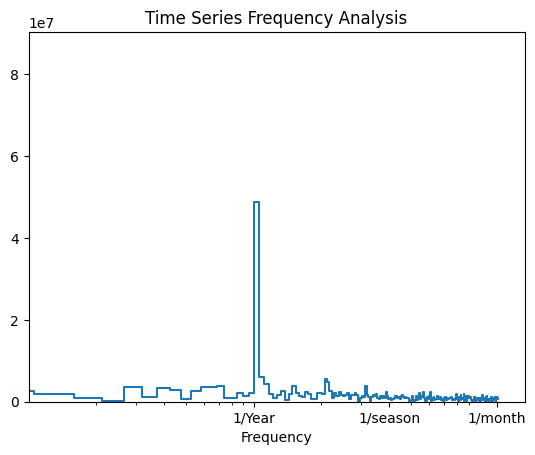

In [23]:
"""
Temporal periodicity analysis of our data set, where it can be seen that it has a very important annual periodicity.
"""

# group dataframe by date 
combined_series = ppna_df_feature_cross.groupby(['date'])['ppna'].sum().sort_index()


# Apply FFT
fft = tf.signal.rfft(combined_series)
f_per_dataset = np.arange(0, len(fft))


n_samples_h = len(combined_series)
f_sample = 15 #1 sample every 15 days 
years_per_dataset = n_samples_h * f_sample / 365  #number of samples * frecuency sample day * num of days in a year give me the number of years 
f_per_year = f_per_dataset / years_per_dataset

# Grafica la amplitud de las frecuencias en una escala de logaritmo.
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, max( np.abs(fft) /2))
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 4, 12], labels=['1/Year', '1/season', '1/month'])
plt.title('Time Series Frequency Analysis' )
plt.xlabel('Frequency')
plt.show()

Text(0.5, 1.0, 'Time signal')

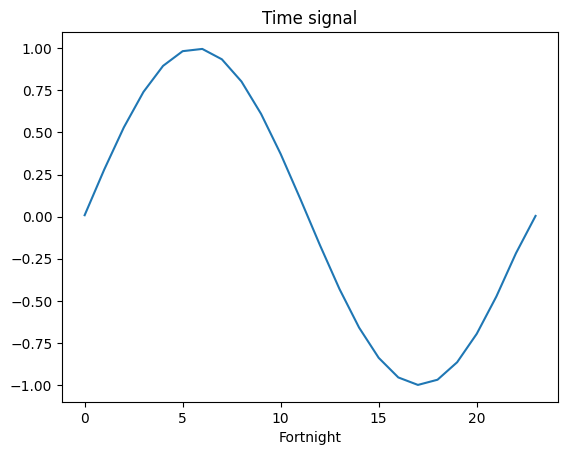

In [24]:
"""
Time in seconds is not a useful input for the model. Being meteorological data, it exhibits clear daily and annual periodicity. There are many ways to deal with this periodicity.
You can obtain usable signals by using sine and cosine transformations to remove the "Time of day" and "Time of year" signals.
As we previously analyzed, the most important time dependence is annual, therefore, we will use a time signal with an annual period.
"""
day = 24*60*60
year = (365.2425)*day


ppna_df_feature_cross['date_signal'] = np.sin(ppna_df_feature_cross['timestamp_date'] * (2 * np.pi / year))

plt.plot(np.array(ppna_df_feature_cross['date_signal'])[:24]) #veinticinco muestras son casi un año (15 * 24 = 360 dias) y vemos ue se cumple un periodo de la señal temporal
plt.xlabel('Fortnight')
plt.title('Time signal')

In [34]:
ppna_df_feature_cross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690000 entries, 0 to 689999
Data columns (total 25 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   id              690000 non-null  int64         
 1   date            690000 non-null  datetime64[ns]
 2   longitude       690000 non-null  float64       
 3   latitude        690000 non-null  float64       
 4   ppna            690000 non-null  float64       
 5   ppt             690000 non-null  float64       
 6   temp            690000 non-null  float64       
 7   cluster_0       690000 non-null  int32         
 8   cluster_1       690000 non-null  int32         
 9   cluster_2       690000 non-null  int32         
 10  cluster_3       690000 non-null  int32         
 11  cluster_4       690000 non-null  int32         
 12  cluster_5       690000 non-null  int32         
 13  cluster_6       690000 non-null  int32         
 14  cluster_7       690000 non-null  int

In [91]:
"""
CHECK CELL ABOVE TO KNOW DF COLUMNS TO DIVIDE CORRECTLY
"""

#ppna_df =  ppna_df[(ppna_df['longitude'] == ppna_df['longitude'][100]) & (ppna_df['latitude'] == ppna_df['latitude'][100])].copy() #-> lo hago para una sola ubicacion, despues hay que ver como cambiar esto 
train_df_feature_cross = DataManager(ppna_df_feature_cross[ppna_df_feature_cross['date'] < '2014-01-01'][[ 'date_signal', 'ppt','temp', 'ppna','cluster_0','cluster_1','cluster_2','cluster_3','cluster_4','cluster_5','cluster_6','cluster_7','cluster_8','cluster_9','cluster_10','cluster_11','cluster_12','cluster_13','cluster_14','cluster_15']])
val_df_feature_cross =  DataManager(ppna_df_feature_cross[(ppna_df_feature_cross['date'] >= '2014-01-01') & (ppna_df_feature_cross['date'] < '2019-01-01')][[ 'date_signal','ppt', 'temp', 'ppna','cluster_0','cluster_1','cluster_2','cluster_3','cluster_4','cluster_5','cluster_6','cluster_7','cluster_8','cluster_9','cluster_10','cluster_11','cluster_12','cluster_13','cluster_14','cluster_15']])
test_df_feature_cross = DataManager(ppna_df_feature_cross[ppna_df_feature_cross['date'] >= '2019-01-01'][['date_signal','ppt','temp', 'ppna','cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7','cluster_8','cluster_9','cluster_10','cluster_11','cluster_12','cluster_13','cluster_14','cluster_15']])

In [92]:
train_df_feature_cross

,date_signal,ppt,temp,ppna,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15
0,0.008300,76.155505,24.333897,405.340618,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0.279761,91.647396,23.921929,362.433361,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0.530160,80.999538,24.132180,420.441046,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0.740648,88.673292,26.170466,335.261458,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0.895377,5.496469,24.043910,301.399079,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689834,-0.968451,100.440600,19.237120,382.557023,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
689835,-0.864268,161.417161,20.620388,380.863376,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
689836,-0.695020,37.594536,21.702648,422.863187,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
689837,-0.473450,21.384484,24.173173,553.473402,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [90]:
ppna_df_feature_cross

,id,date,longitude,latitude,ppna,ppt,temp,cluster_0,cluster_1,cluster_2,...,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,timestamp_date,date_signal
0,0,2001-01-01,-56.832420,-31.544792,405.340618,76.155505,24.333897,0,0,0,...,0,0,0,0,0,0,0,0,9.783072e+08,0.008300
1,1,2001-01-17,-56.832420,-31.544792,362.433361,91.647396,23.921929,0,0,0,...,0,0,0,0,0,0,0,0,9.796896e+08,0.279761
2,2,2001-02-02,-56.832420,-31.544792,420.441046,80.999538,24.132180,0,0,0,...,0,0,0,0,0,0,0,0,9.810720e+08,0.530160
3,3,2001-02-18,-56.832420,-31.544792,335.261458,88.673292,26.170466,0,0,0,...,0,0,0,0,0,0,0,0,9.824544e+08,0.740648
4,4,2001-03-06,-56.832420,-31.544792,301.399079,5.496469,24.043910,0,0,0,...,0,0,0,0,0,0,0,0,9.838368e+08,0.895377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689995,689995,2020-10-15,-57.716514,-31.594792,358.278813,38.972820,21.318121,0,0,0,...,0,0,0,0,0,0,1,0,1.602720e+09,-0.971371
689996,689996,2020-10-31,-57.716514,-31.594792,458.887961,6.287209,20.565697,0,0,0,...,0,0,0,0,0,0,1,0,1.604102e+09,-0.870241
689997,689997,2020-11-16,-57.716514,-31.594792,385.684877,61.482739,23.886589,0,0,0,...,0,0,0,0,0,0,1,0,1.605485e+09,-0.703597
689998,689998,2020-12-02,-57.716514,-31.594792,358.895048,113.424375,22.063381,0,0,0,...,0,0,0,0,0,0,1,0,1.606867e+09,-0.483985


In [49]:
train_df_feature_cross.normalize_data()
val_df_feature_cross.normalize_data()
test_df_feature_cross.normalize_data()

In [84]:
test_df_feature_cross.info()


<class '__main__.DataManager'>
Index: 69000 entries, 414 to 689999
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ppna         69000 non-null  float64
 1   date_signal  69000 non-null  float64
 2   ppt          69000 non-null  float64
 3   temp         69000 non-null  float64
 4   cluster_0    69000 non-null  int32  
 5   cluster_1    69000 non-null  int32  
 6   cluster_2    69000 non-null  int32  
 7   cluster_3    69000 non-null  int32  
 8   cluster_4    69000 non-null  int32  
 9   cluster_5    69000 non-null  int32  
 10  cluster_6    69000 non-null  int32  
 11  cluster_7    69000 non-null  int32  
 12  cluster_8    69000 non-null  int32  
 13  cluster_9    69000 non-null  int32  
 14  cluster_10   69000 non-null  int32  
 15  cluster_11   69000 non-null  int32  
 16  cluster_12   69000 non-null  int32  
 17  cluster_13   69000 non-null  int32  
 18  cluster_14   69000 non-null  int32  
 19  cluster_15   

In [85]:
test_df_feature_cross

,ppna,date_signal,ppt,temp,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15
414,0.699160,0.002021,3.914494,1.087036,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
415,0.978394,0.273727,2.007247,1.294414,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
416,1.589300,0.524826,-0.767081,0.825184,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
417,1.516624,0.736414,-0.341211,1.007418,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
418,0.792573,0.892564,-0.116655,0.459468,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689995,0.671663,-0.971371,-0.325739,0.654572,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
689996,1.489281,-0.870241,-0.881311,0.493504,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
689997,0.894384,-0.703597,0.056872,1.204392,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
689998,0.676671,-0.483985,0.939748,0.814106,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [87]:
def denormalize_data(self):
        mean = self.mean()
        std = self.std()
        self[['ppna', 'ppt', 'temp']] = self[['ppna', 'ppt', 'temp']] * std[['ppna', 'ppt', 'temp']] + mean[['ppna', 'ppt', 'temp']]

In [88]:
denormalize_data(test_df_feature_cross)

In [89]:
test_df_feature_cross

,ppna,date_signal,ppt,temp,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15
414,0.699160,0.002021,3.914494,1.087036,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
415,0.978394,0.273727,2.007247,1.294414,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
416,1.589300,0.524826,-0.767081,0.825184,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
417,1.516624,0.736414,-0.341211,1.007418,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
418,0.792573,0.892564,-0.116655,0.459468,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689995,0.671663,-0.971371,-0.325739,0.654572,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
689996,1.489281,-0.870241,-0.881311,0.493504,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
689997,0.894384,-0.703597,0.056872,1.204392,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
689998,0.676671,-0.483985,0.939748,0.814106,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
#PRE: The DataManager df must be previously normalised and the first column must be "ppna" . 
        # mean and std must be loaded with that information from the normalised columns.
    #POST: de-normalises the "ppna" column from de df.
def denormalize_data(self, mean, std):
    self[0] = self[0] * std['ppna'] + mean['ppna']

In [50]:
INPUT_STEPS = 24 #1 Year
OUTPUT_STEPS = 12 #15 DAYS
train_sequence_feature_cross, train_labels_feature_cross = train_df_feature_cross.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
val_sequence_feature_cross, val_labels_feature_cross = val_df_feature_cross.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
test_sequence_feature_cross, test_labels_feature_cross = test_df_feature_cross.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
print("train sequence: (num train data, past_data, features) ->", train_sequence_feature_cross.shape)
print("label sequence: (num train data, label, 1) -> ", train_labels_feature_cross.shape)

train sequence: (num train data, past_data, features) -> (448465, 24, 20)
label sequence: (num train data, label, 1) ->  (448465, 12)


In [ ]:
'''
#COMENTADO PORQUE SE HACE CON EL SEQUENCE_DATA_PREPARATION

INPUT_STEPS = 24 #1 Year
OUTPUT_STEPS = 1 #15 DAYS

train_sequence = []  # Window for the past 
train_labels = []  # Predict next value 

for i in range(train_df_feature_cross.shape[0] - int(INPUT_STEPS + OUTPUT_STEPS - 1)):
    a = train_df_feature_cross[i: i + INPUT_STEPS + OUTPUT_STEPS] 
    train_sequence.append(a[:INPUT_STEPS])
    train_labels.append(a[-1:]['ppna'])

train_sequence = np.array(train_sequence)
train_labels = np.array(train_labels)
'''

"\n#COMENTADO PORQUE SE HACE CON EL SEQUENCE_DATA_PREPARATION\n\nINPUT_STEPS = 24 #1 Year\nOUTPUT_STEPS = 1 #15 DAYS\n\ntrain_sequence = []  # Window for the past \ntrain_labels = []  # Predict next value \n\nfor i in range(train_df_feature_cross.shape[0] - int(INPUT_STEPS + OUTPUT_STEPS - 1)):\n    a = train_df_feature_cross[i: i + INPUT_STEPS + OUTPUT_STEPS] \n    train_sequence.append(a[:INPUT_STEPS])\n    train_labels.append(a[-1:]['ppna'])\n\ntrain_sequence = np.array(train_sequence)\ntrain_labels = np.array(train_labels)\n"

In [ ]:
'''
#COMENTADO PORQUE SE HACE CON EL SEQUENCE_DATA_PREPARATION

INPUT_STEPS = 24 #1 Year
OUTPUT_STEPS = 1 #15 DAYS

val_sequence = []  # Window for the past 
val_labels = []  # Predict next value 

for i in range(val_df_feature_cross.shape[0] - int(INPUT_STEPS + OUTPUT_STEPS - 1)):
    a = val_df_feature_cross[i: i + INPUT_STEPS + OUTPUT_STEPS] 
    val_sequence.append(a[:INPUT_STEPS])
    val_labels.append(a[-1:]['ppna'])

val_sequence = np.array(val_sequence)
val_labels = np.array(val_labels)
'''

"\n#COMENTADO PORQUE SE HACE CON EL SEQUENCE_DATA_PREPARATION\n\nINPUT_STEPS = 24 #1 Year\nOUTPUT_STEPS = 1 #15 DAYS\n\nval_sequence = []  # Window for the past \nval_labels = []  # Predict next value \n\nfor i in range(val_df_feature_cross.shape[0] - int(INPUT_STEPS + OUTPUT_STEPS - 1)):\n    a = val_df_feature_cross[i: i + INPUT_STEPS + OUTPUT_STEPS] \n    val_sequence.append(a[:INPUT_STEPS])\n    val_labels.append(a[-1:]['ppna'])\n\nval_sequence = np.array(val_sequence)\nval_labels = np.array(val_labels)\n"

In [ ]:
'''
#COMENTADO PORQUE SE HACE CON EL SEQUENCE_DATA_PREPARATION

INPUT_STEPS = 24 #1 Year
OUTPUT_STEPS = 1 #15 DAYS

test_sequence = []  # Window for the past 
test_labels = []  # Predict next value 

for i in range(test_df_feature_cross.shape[0] - int(INPUT_STEPS + OUTPUT_STEPS - 1)):
    a = test_df_feature_cross[i: i + INPUT_STEPS + OUTPUT_STEPS] 
    test_sequence.append(a[:INPUT_STEPS])
    test_labels.append(a[-1:]['ppna'])

test_sequence = np.array(test_sequence)
test_labels = np.array(test_labels)
'''

"\n#COMENTADO PORQUE SE HACE CON EL SEQUENCE_DATA_PREPARATION\n\nINPUT_STEPS = 24 #1 Year\nOUTPUT_STEPS = 1 #15 DAYS\n\ntest_sequence = []  # Window for the past \ntest_labels = []  # Predict next value \n\nfor i in range(test_df_feature_cross.shape[0] - int(INPUT_STEPS + OUTPUT_STEPS - 1)):\n    a = test_df_feature_cross[i: i + INPUT_STEPS + OUTPUT_STEPS] \n    test_sequence.append(a[:INPUT_STEPS])\n    test_labels.append(a[-1:]['ppna'])\n\ntest_sequence = np.array(test_sequence)\ntest_labels = np.array(test_labels)\n"

In [51]:
"""
Neuronal Network Model for LSTM one shot 
"""

LEARNING_RATE = 0.000005

model_one_shot_cluster = tf.keras.Sequential()

model_one_shot_cluster.add(Input((INPUT_STEPS, train_df_feature_cross.shape[1])))

model_one_shot_cluster.add(LSTM(64))

model_one_shot_cluster.add(Dense(16,'relu'))

model_one_shot_cluster.add(Dense(OUTPUT_STEPS * 1,'linear'))

model_one_shot_cluster.summary()

model_one_shot_cluster.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate=LEARNING_RATE),
                metrics=[tf.metrics.RootMeanSquaredError()])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='root_mean_squared_error',
                                                patience=2,
                                                mode='min')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                21760     
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 12)                204       
                                                                 
Total params: 23004 (89.86 KB)
Trainable params: 23004 (89.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [52]:


EPOCHS = 5
history = model_one_shot_cluster.fit(train_sequence_feature_cross, train_labels_feature_cross, validation_data=(val_sequence_feature_cross,val_labels_feature_cross), epochs=EPOCHS, batch_size=32, callbacks=[early_stopping])

Epoch 1/5
14015/14015 [==============================] - 228s 11ms/step - loss: 0.5871 - root_mean_squared_error: 0.7662 - val_loss: 0.3014 - val_root_mean_squared_error: 0.5490
Epoch 2/5
14015/14015 [==============================] - 150s 11ms/step - loss: 0.2903 - root_mean_squared_error: 0.5388 - val_loss: 0.2297 - val_root_mean_squared_error: 0.4792
Epoch 3/5
14015/14015 [==============================] - 149s 11ms/step - loss: 0.2561 - root_mean_squared_error: 0.5060 - val_loss: 0.2277 - val_root_mean_squared_error: 0.4772
Epoch 4/5
14015/14015 [==============================] - 146s 10ms/step - loss: 0.2443 - root_mean_squared_error: 0.4943 - val_loss: 0.2332 - val_root_mean_squared_error: 0.4829
Epoch 5/5
14015/14015 [==============================] - 160s 11ms/step - loss: 0.2342 - root_mean_squared_error: 0.4839 - val_loss: 0.2385 - val_root_mean_squared_error: 0.4883


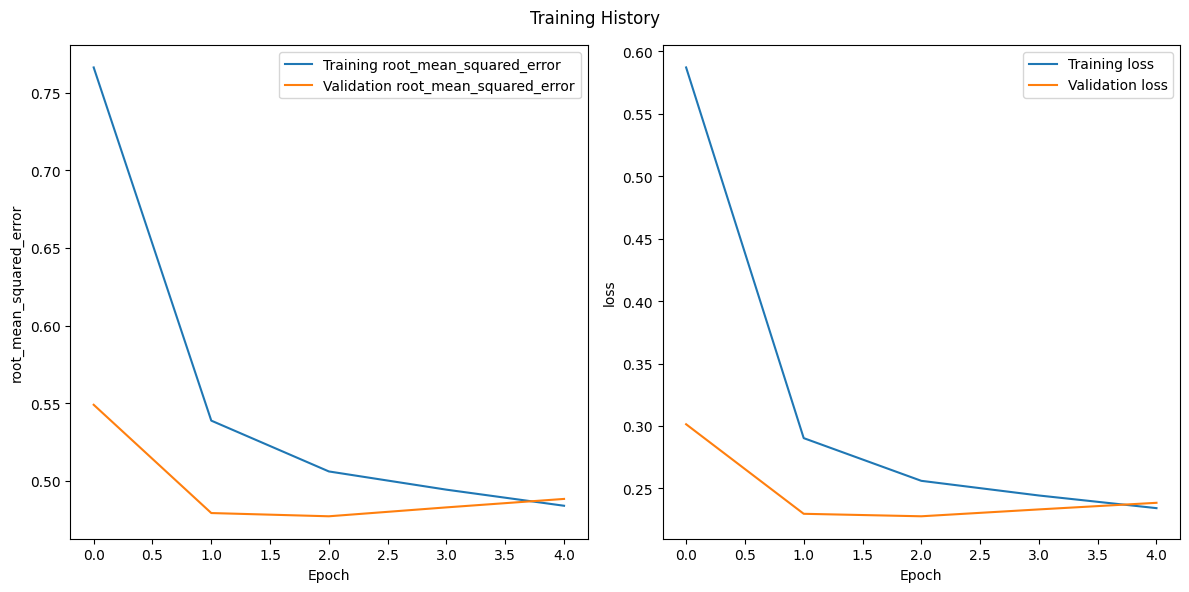

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
pd.options.mode.chained_assignment = None

  
# plot training history
Utils.plot_training_history(axes[0], history, "root_mean_squared_error")
Utils.plot_training_history(axes[1], history, "loss")

# Mostrar el gráfico
fig.suptitle("Training History")
fig.tight_layout()
plt.show()


In [103]:
"""
Evaluate the model over the validation data, if the metrics are not good, change the model an test again
"""
metric = model_one_shot_cluster.evaluate(val_sequence_feature_cross, val_labels_feature_cross)

print("The values of Loss and Root Mean Squared Error are: ", metric)

5390/5390 [==============================] - 36s 7ms/step - loss: 0.1594 - root_mean_squared_error: 0.3685
The values of Loss and Root Mean Squared Error are:  [0.15935879945755005, 0.36852118372917175]


In [42]:

ppna_df_feature_cross.head()
#test_df_feature_cross.head()

,id,date,longitude,latitude,ppna,ppt,temp,cluster_0,cluster_1,cluster_2,...,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,timestamp_date,date_signal
0,0,2001-01-01,-56.83242,-31.544792,405.340618,76.155505,24.333897,0,0,0,...,0,0,0,0,0,0,0,0,978307200.0,0.008300
1,1,2001-01-17,-56.83242,-31.544792,362.433361,91.647396,23.921929,0,0,0,...,0,0,0,0,0,0,0,0,979689600.0,0.279761
2,2,2001-02-02,-56.83242,-31.544792,420.441046,80.999538,24.132180,0,0,0,...,0,0,0,0,0,0,0,0,981072000.0,0.530160
3,3,2001-02-18,-56.83242,-31.544792,335.261458,88.673292,26.170466,0,0,0,...,0,0,0,0,0,0,0,0,982454400.0,0.740648
4,4,2001-03-06,-56.83242,-31.544792,301.399079,5.496469,24.043910,0,0,0,...,0,0,0,0,0,0,0,0,983836800.0,0.895377


train sequence: (num train data, past_data, features) -> (11, 24, 22)
label sequence: (num train data, label) ->  (11, 12)
1/1 [==============================] - 4s 4s/step


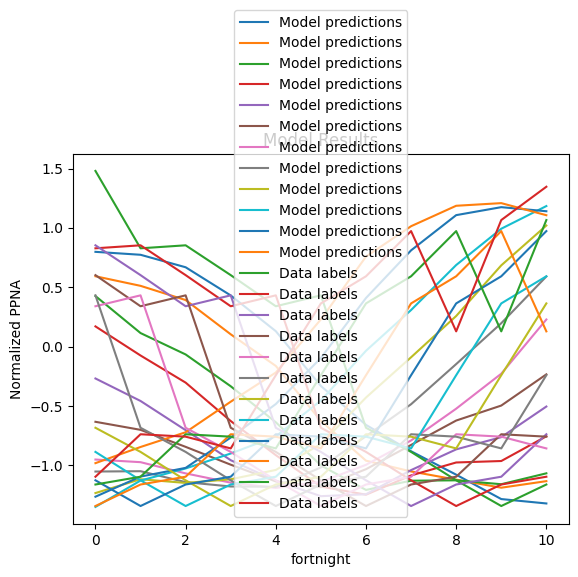

In [43]:
"""
Test the model and view the results: In this case, the model is tested over a fixed location 
"""

test_sequence_fixed_position_df = DataManager(test_df_feature_cross[(test_df_feature_cross['longitude'] == ppna_df_feature_cross['longitude'][40000]) & (test_df_feature_cross['latitude'] == ppna_df_feature_cross['latitude'][40000])])
test_sequence_fixed_position , test_labels_fixed_position = test_sequence_fixed_position_df.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
print("train sequence: (num train data, past_data, features) ->", test_sequence_fixed_position.shape )
print("label sequence: (num train data, label) -> ", test_labels_fixed_position.shape)

predict = model_one_shot_cluster.predict(test_sequence_fixed_position)

plt.title("Model Results")
plt.plot(predict, label="Model predictions")
plt.plot(test_labels_fixed_position, label="Data labels")


plt.xlabel("fortnight")
plt.ylabel("Normalized PPNA")
plt.legend()
plt.show()

In [44]:
index_slider = widgets.IntSlider(min=0, max=OUTPUT_STEPS-2 , step=1, value=0, description='Fortnight:', layout=widgets.Layout(width='60%', margin='0px 0px 0px 0px'))

def plot_result_in_fixed_position_feature_cross(ax, longitude, latitude, index, model): 
        test_sequence_fixed_position_df = DataManager(test_df_feature_cross[(test_df_feature_cross['longitude'] == longitude) & (test_df_feature_cross['latitude'] == latitude)])
        test_sequence_fixed_position, test_labels_fixed_position = test_sequence_fixed_position_df.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
        predict = model.predict(test_sequence_fixed_position, verbose=0)
        ax.plot(test_sequence_fixed_position[index,:, -1], label='Input data')
        ax.plot(range(INPUT_STEPS , OUTPUT_STEPS  + INPUT_STEPS), predict[index], label="Model predictions")
        ax.plot(range(INPUT_STEPS , OUTPUT_STEPS  + INPUT_STEPS), test_labels_fixed_position[index], label="Data labels")
        ax.set_xlabel("fortnight")  
        ax.set_ylabel("Normalized PPNA") 
        ax.set_title(f"Prediction for location ['{longitude}','{latitude}']")
        ax.legend()


def update_plot(index):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    fig.suptitle('Model Resuts')
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)
    plot_result_in_fixed_position_feature_cross(axes[0,0],ppna_df_feature_cross['longitude'][400000], ppna_df_feature_cross['latitude'][400000],index, model_one_shot_cluster)
    plot_result_in_fixed_position_feature_cross(axes[0,1],ppna_df_feature_cross['longitude'][0], ppna_df_feature_cross['latitude'][0],index, model_one_shot_cluster)
    plot_result_in_fixed_position_feature_cross(axes[1,0],ppna_df_feature_cross['longitude'][10000], ppna_df_feature_cross['latitude'][10000],index, model_one_shot_cluster)
    plot_result_in_fixed_position_feature_cross(axes[1,1],ppna_df_feature_cross['longitude'][30000], ppna_df_feature_cross['latitude'][30000],index,  model_one_shot_cluster)
    


widgets.interactive(update_plot, index=index_slider)

interactive(children=(IntSlider(value=0, description='Fortnight:', layout=Layout(margin='0px 0px 0px 0px', wid…

In [32]:
import numpy as np

# Obtener las predicciones del modelo
predictions = model_one_shot_cluster.predict(test_sequence_feature_cross)

# Extraer las predicciones de "ppna" de las predicciones del modelo
ppna_predictions = predictions[:, 0]  # Obtener todas las muestras para el primer paso de tiempo

# Aplanar las predicciones y convertirlas en una lista
ppna_predictions_flat = ppna_predictions.flatten().tolist()


# Ahora tienes una lista con todas las predicciones de "ppna"
import pandas as pd

# Crear un DataFrame con las ppna reales y las predicciones
ppna_comparison_df = pd.DataFrame({'Real PPNA': val_labels_feature_cross.flatten(), 'Predicción PPNA': ppna_predictions})

# Mostrar el DataFrame
print(ppna_comparison_df)


2156/2156 [==============================] - 38s 8ms/step


ValueError: All arrays must be of the same length

In [94]:
print("Longitud de test_label_feature_cross:", len(test_labels_feature_cross))
print("Longitud de ppna_predictions:", len(ppna_predictions))
print("Long de test df", len(test_df_feature_cross))

Longitud de test_label_feature_cross: 68965
Longitud de ppna_predictions: 68965
Long de test df 69000


In [93]:
test_df_feature_cross

,date_signal,ppt,temp,ppna,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15
414,0.002021,288.435732,23.338363,361.662357,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
415,0.273727,176.227922,24.307123,396.022460,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
416,0.524826,13.007584,22.115131,471.195501,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
417,0.736414,38.062536,22.966432,462.252539,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
418,0.892564,51.273700,20.406701,373.156882,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689995,-0.971371,38.972820,21.318121,358.278813,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
689996,-0.870241,6.287209,20.565697,458.887961,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
689997,-0.703597,61.482739,23.886589,385.684877,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
689998,-0.483985,113.424375,22.063381,358.895048,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
predictions

array([[ 0.99459904,  0.77517676,  0.602439  , ..., -1.2736003 ,
        -1.3158966 , -1.1129938 ],
       [ 0.9050791 ,  0.67633015,  0.3561072 , ..., -1.2022563 ,
        -1.2209437 , -0.9614502 ],
       [ 0.7483402 ,  0.4934221 ,  0.01819012, ..., -1.0776572 ,
        -1.092385  , -0.78861344],
       ...,
       [-1.1205779 , -1.182142  , -1.1956818 , ...,  0.7292016 ,
         1.099781  ,  1.2652919 ],
       [-1.2424449 , -1.1942183 , -1.1965529 , ...,  1.084233  ,
         1.2282991 ,  1.2400938 ],
       [-1.2946517 , -1.1178421 , -1.1181587 , ...,  1.2658494 ,
         1.1997739 ,  1.1567928 ]], dtype=float32)

In [34]:
predictions[:,0]

array([ 1.1381425 ,  0.9311417 ,  0.66427857, ..., -1.0805749 ,
       -1.2167217 , -1.2791576 ], dtype=float32)

In [68]:
print(test_df_feature_cross.columns)


Index(['date_signal', 'ppt', 'temp', 'ppna', 'cluster_0', 'cluster_1',
       'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6',
       'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10', 'cluster_11',
       'cluster_12', 'cluster_13', 'cluster_14', 'cluster_15'],
      dtype='object')


In [69]:
# Obtener la columna de "ppna"
ppna_column = test_df_feature_cross.pop('ppna')

# Insertar la columna de "ppna" como la primera columna en el DataFrame
test_df_feature_cross.insert(0, "ppna", ppna_column)


In [70]:
print(test_df_feature_cross.columns)


Index(['ppna', 'date_signal', 'ppt', 'temp', 'cluster_0', 'cluster_1',
       'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6',
       'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10', 'cluster_11',
       'cluster_12', 'cluster_13', 'cluster_14', 'cluster_15'],
      dtype='object')


In [71]:
test_df_feature_cross

,ppna,date_signal,ppt,temp,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15
414,0.699160,0.002021,3.914494,1.087036,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
415,0.978394,0.273727,2.007247,1.294414,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
416,1.589300,0.524826,-0.767081,0.825184,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
417,1.516624,0.736414,-0.341211,1.007418,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
418,0.792573,0.892564,-0.116655,0.459468,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689995,0.671663,-0.971371,-0.325739,0.654572,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
689996,1.489281,-0.870241,-0.881311,0.493504,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
689997,0.894384,-0.703597,0.056872,1.204392,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
689998,0.676671,-0.483985,0.939748,0.814106,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [124]:
mean_test =test_df_feature_cross['ppna'].mean
std_test = test_df_feature_cross['ppna'].std

print(mean_test)
print(std_test)

<bound method Series.mean of 414       361.662357
415       396.022460
416       471.195501
417       462.252539
418       373.156882
             ...    
689995    358.278813
689996    458.887961
689997    385.684877
689998    358.895048
689999    504.507698
Name: ppna, Length: 69000, dtype: float64>
<bound method Series.std of 414       361.662357
415       396.022460
416       471.195501
417       462.252539
418       373.156882
             ...    
689995    358.278813
689996    458.887961
689997    385.684877
689998    358.895048
689999    504.507698
Name: ppna, Length: 69000, dtype: float64>


In [72]:
        

    #PRE: The DataManager df must be previously normalised and the first column must be "ppna" . 
        # mean and std must be loaded with that information from the normalised columns.
    #POST: de-normalises the "ppna" column from de df.
train_df_feature_cross[0] = train_df_feature_cross[0] * std['ppna'] + mean['ppna']


KeyError: 0

In [95]:
#We get a dataset with only cluster1 data
test_df_feature_cross_cluster0 = test_df_feature_cross[test_df_feature_cross.cluster_0 != 0]
test_df_feature_cross_cluster1 = test_df_feature_cross[test_df_feature_cross.cluster_1 != 0]
test_df_feature_cross_cluster2 = test_df_feature_cross[test_df_feature_cross.cluster_2 != 0]
test_df_feature_cross_cluster3 = test_df_feature_cross[test_df_feature_cross.cluster_3 != 0]
test_df_feature_cross_cluster4 = test_df_feature_cross[test_df_feature_cross.cluster_4 != 0]
test_df_feature_cross_cluster5 = test_df_feature_cross[test_df_feature_cross.cluster_5 != 0]
test_df_feature_cross_cluster6 = test_df_feature_cross[test_df_feature_cross.cluster_6 != 0]
test_df_feature_cross_cluster7 = test_df_feature_cross[test_df_feature_cross.cluster_7 != 0]
test_df_feature_cross_cluster8 = test_df_feature_cross[test_df_feature_cross.cluster_8 != 0]
test_df_feature_cross_cluster9 = test_df_feature_cross[test_df_feature_cross.cluster_9 != 0]
test_df_feature_cross_cluster10 = test_df_feature_cross[test_df_feature_cross.cluster_10 != 0]
test_df_feature_cross_cluster11 = test_df_feature_cross[test_df_feature_cross.cluster_11 != 0]
test_df_feature_cross_cluster12 = test_df_feature_cross[test_df_feature_cross.cluster_12 != 0]
test_df_feature_cross_cluster13 = test_df_feature_cross[test_df_feature_cross.cluster_13 != 0]
test_df_feature_cross_cluster14 = test_df_feature_cross[test_df_feature_cross.cluster_14 != 0]
test_df_feature_cross_cluster15 = test_df_feature_cross[test_df_feature_cross.cluster_15 != 0]


In [100]:
test_df_feature_cross_cluster0 = DataManager(test_df_feature_cross_cluster0)
test_df_feature_cross_cluster1 = DataManager(test_df_feature_cross_cluster1)
test_df_feature_cross_cluster2 = DataManager(test_df_feature_cross_cluster2)
test_df_feature_cross_cluster3 = DataManager(test_df_feature_cross_cluster3)
test_df_feature_cross_cluster4 = DataManager(test_df_feature_cross_cluster4)
test_df_feature_cross_cluster5 = DataManager(test_df_feature_cross_cluster5)
test_df_feature_cross_cluster6 = DataManager(test_df_feature_cross_cluster6)
test_df_feature_cross_cluster7 = DataManager(test_df_feature_cross_cluster7)
test_df_feature_cross_cluster8 = DataManager(test_df_feature_cross_cluster8)
test_df_feature_cross_cluster9 = DataManager(test_df_feature_cross_cluster9)
test_df_feature_cross_cluster10 = DataManager(test_df_feature_cross_cluster10)
test_df_feature_cross_cluster11 = DataManager(test_df_feature_cross_cluster11)
test_df_feature_cross_cluster12 = DataManager(test_df_feature_cross_cluster12)
test_df_feature_cross_cluster13 = DataManager(test_df_feature_cross_cluster13)
test_df_feature_cross_cluster14 = DataManager(test_df_feature_cross_cluster14)
test_df_feature_cross_cluster15 = DataManager(test_df_feature_cross_cluster15)


In [103]:

test_sequence_cluster0, test_labels_cluster0 = test_df_feature_cross_cluster0.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
test_sequence_cluster1, test_labels_cluster1 = test_df_feature_cross_cluster1.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
test_sequence_cluster2, test_labels_cluster2 = test_df_feature_cross_cluster2.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
test_sequence_cluster3, test_labels_cluster3 = test_df_feature_cross_cluster3.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
test_sequence_cluster4, test_labels_cluster4 = test_df_feature_cross_cluster4.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
test_sequence_cluster5, test_labels_cluster5 = test_df_feature_cross_cluster5.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
test_sequence_cluster6, test_labels_cluster6 = test_df_feature_cross_cluster6.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
test_sequence_cluster7, test_labels_cluster7 = test_df_feature_cross_cluster7.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
test_sequence_cluster8, test_labels_cluster8 = test_df_feature_cross_cluster8.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
test_sequence_cluster9, test_labels_cluster9 = test_df_feature_cross_cluster9.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
test_sequence_cluster10, test_labels_cluster10 = test_df_feature_cross_cluster10.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
test_sequence_cluster11, test_labels_cluster11 = test_df_feature_cross_cluster11.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
test_sequence_cluster12, test_labels_cluster12 = test_df_feature_cross_cluster12.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
test_sequence_cluster13, test_labels_cluster13 = test_df_feature_cross_cluster13.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
test_sequence_cluster14, test_labels_cluster14 = test_df_feature_cross_cluster14.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
test_sequence_cluster15, test_labels_cluster15 = test_df_feature_cross_cluster15.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)


In [118]:
predict_test = model_one_shot_cluster.predict(test_sequence_feature_cross)

2156/2156 [==============================] - 10s 5ms/step


In [119]:
predict_test

array([[ 1.0000432 ,  0.80265486,  0.5372437 , ..., -1.4072776 ,
        -1.3131175 , -1.1462349 ],
       [ 0.80521584,  0.65494883,  0.32221398, ..., -1.4339674 ,
        -1.2129879 , -0.9448031 ],
       [ 0.5244022 ,  0.35330462,  0.02026631, ..., -1.3487679 ,
        -1.0420679 , -0.7132001 ],
       ...,
       [-1.1108198 , -1.2541702 , -1.3950325 , ...,  0.7751625 ,
         1.1151644 ,  1.3398622 ],
       [-1.346807  , -1.2928563 , -1.3574457 , ...,  1.1925186 ,
         1.3488781 ,  1.3373485 ],
       [-1.3376938 , -1.2144723 , -1.1175863 , ...,  1.2535627 ,
         1.2709368 ,  1.1916643 ]], dtype=float32)

In [120]:
import pandas as pd

# Crear un DataFrame vacío
ppna_predict_df = pd.DataFrame()

# Iterar sobre cada array y agregarlo al DataFrame como una nueva fila
for i, array in enumerate(predict_test):
    df = pd.DataFrame(array.reshape(1, -1), columns=[f'ppna_{j+1}' for j in range(len(array))])
    ppna_predict_df = ppna_predict_df.append(df, ignore_index=True)

# Mostrar el DataFrame resultante
print(ppna_predict_df)


AttributeError: 'DataFrame' object has no attribute 'append'

In [121]:
import pandas as pd

# Lista para almacenar los DataFrames individuales
ppna_predict_dfs = []

# Iterar sobre cada array y agregarlo al DataFrame como una nueva fila
for i, array in enumerate(predict_test):
    # Crear un DataFrame para el array actual
    df = pd.DataFrame(array.reshape(1, -1), columns=[f'ppna_{j+1}' for j in range(len(array))])
    # Agregar el DataFrame a la lista
    ppna_predict_dfs.append(df)

# Concatenar todos los DataFrames en uno solo
ppna_predict_df = pd.concat(ppna_predict_dfs, ignore_index=True)

# Mostrar el DataFrame resultante
print(ppna_predict_df)


         ppna_1    ppna_2    ppna_3    ppna_4    ppna_5    ppna_6    ppna_7  \
0      1.000043  0.802655  0.537244  0.373028  0.009424 -0.342064 -0.744963   
1      0.805216  0.654949  0.322214  0.077723 -0.297264 -0.671251 -0.895878   
2      0.524402  0.353305  0.020266 -0.306693 -0.636021 -0.966359 -1.067623   
3      0.310876  0.089957 -0.215159 -0.611068 -0.884340 -1.202141 -1.133114   
4     -0.030573 -0.351967 -0.594147 -0.963866 -1.094077 -1.303337 -1.246971   
...         ...       ...       ...       ...       ...       ...       ...   
68960 -0.696609 -1.081126 -1.198025 -1.343309 -1.300754 -1.273863 -1.144240   
68961 -0.862440 -1.131070 -1.266356 -1.193882 -1.072845 -1.012005 -0.950270   
68962 -1.110820 -1.254170 -1.395033 -1.163960 -0.980229 -0.735015 -0.610784   
68963 -1.346807 -1.292856 -1.357446 -1.038162 -0.875713 -0.412132 -0.164178   
68964 -1.337694 -1.214472 -1.117586 -0.817194 -0.568929 -0.076259  0.230082   

         ppna_8    ppna_9   ppna_10   ppna_11   ppn

In [133]:
test_df_feature_cross.normalize_data()

In [134]:
test_df_feature_cross

,date_signal,ppt,temp,ppna,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15
414,0.002021,3.914494,1.087036,0.699160,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
415,0.273727,2.007247,1.294414,0.978394,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
416,0.524826,-0.767081,0.825184,1.589300,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
417,0.736414,-0.341211,1.007418,1.516624,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
418,0.892564,-0.116655,0.459468,0.792573,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689995,-0.971371,-0.325739,0.654572,0.671663,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
689996,-0.870241,-0.881311,0.493504,1.489281,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
689997,-0.703597,0.056872,1.204392,0.894384,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
689998,-0.483985,0.939748,0.814106,0.676671,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [135]:
# Concatenar las bases de datos test_df_feature_cross y ppna_predict_df
merged_df = pd.concat([test_df_feature_cross, ppna_predict_df], axis=1)

# Mostrar el DataFrame resultante
print(merged_df)


       date_signal       ppt      temp      ppna  cluster_0  cluster_1  \
414       0.002021  3.914494  1.087036  0.699160        0.0        0.0   
415       0.273727  2.007247  1.294414  0.978394        0.0        0.0   
416       0.524826 -0.767081  0.825184  1.589300        0.0        0.0   
417       0.736414 -0.341211  1.007418  1.516624        0.0        0.0   
418       0.892564 -0.116655  0.459468  0.792573        0.0        0.0   
...            ...       ...       ...       ...        ...        ...   
68949          NaN       NaN       NaN       NaN        NaN        NaN   
68950          NaN       NaN       NaN       NaN        NaN        NaN   
68951          NaN       NaN       NaN       NaN        NaN        NaN   
68952          NaN       NaN       NaN       NaN        NaN        NaN   
68953          NaN       NaN       NaN       NaN        NaN        NaN   

       cluster_2  cluster_3  cluster_4  cluster_5  ...    ppna_3    ppna_4  \
414          0.0        0.0      

In [136]:
# Guardar el DataFrame como un archivo Excel
merged_df.to_excel('merged_data.xlsx', index=False)


In [125]:

ppna_predict_df['ppna_1'] = ppna_predict_df['ppna_1'] * std_test['ppna'] + mean_test['ppna']

TypeError: 'method' object is not subscriptable

,date_signal,ppt,temp,ppna,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15
414,0.002021,288.435732,23.338363,361.662357,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
415,0.273727,176.227922,24.307123,396.022460,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
416,0.524826,13.007584,22.115131,471.195501,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
417,0.736414,38.062536,22.966432,462.252539,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
418,0.892564,51.273700,20.406701,373.156882,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689995,-0.971371,38.972820,21.318121,358.278813,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
689996,-0.870241,6.287209,20.565697,458.887961,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
689997,-0.703597,61.482739,23.886589,385.684877,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
689998,-0.483985,113.424375,22.063381,358.895048,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
# Concatenar las bases de datos test_df_feature_cross y ppna_predict_df
merged_df = pd.concat([test_df_feature_cross, ppna_predict_df], axis=1)

# Mostrar el DataFrame resultante
print(merged_df)


In [111]:
predictions_cluster0 = model_one_shot_cluster.predict(test_sequence_cluster0)
predictions_cluster1 = model_one_shot_cluster.predict(test_sequence_cluster1)
predictions_cluster2 = model_one_shot_cluster.predict(test_sequence_cluster2)
predictions_cluster3 = model_one_shot_cluster.predict(test_sequence_cluster3)
predictions_cluster4 = model_one_shot_cluster.predict(test_sequence_cluster4)
predictions_cluster5 = model_one_shot_cluster.predict(test_sequence_cluster5)
predictions_cluster6 = model_one_shot_cluster.predict(test_sequence_cluster6)
predictions_cluster7 = model_one_shot_cluster.predict(test_sequence_cluster7)
predictions_cluster8 = model_one_shot_cluster.predict(test_sequence_cluster8)
predictions_cluster9 = model_one_shot_cluster.predict(test_sequence_cluster9)
predictions_cluster10 = model_one_shot_cluster.predict(test_sequence_cluster10)
predictions_cluster11 = model_one_shot_cluster.predict(test_sequence_cluster11)
predictions_cluster12 = model_one_shot_cluster.predict(test_sequence_cluster12)
predictions_cluster13 = model_one_shot_cluster.predict(test_sequence_cluster13)
predictions_cluster14 = model_one_shot_cluster.predict(test_sequence_cluster14)
predictions_cluster15 = model_one_shot_cluster.predict(test_sequence_cluster15)


165/165 [==============================] - 1s 4ms/step


In [112]:
predictions_cluster1

array([[ 1.1075702 ,  1.2172925 ,  1.1170676 , ..., -1.6253715 ,
        -1.4014801 , -0.45536986],
       [ 1.1359228 ,  1.1673281 ,  1.2029278 , ..., -1.6252708 ,
        -1.4417938 , -0.49248436],
       [ 1.1329663 ,  1.1745635 ,  1.1918014 , ..., -1.6447045 ,
        -1.460672  , -0.48039463],
       ...,
       [ 1.0343258 ,  0.9683932 ,  1.3551114 , ..., -1.6321831 ,
        -1.7440251 , -0.55538106],
       [ 0.99664265,  0.9629146 ,  1.2861905 , ..., -1.5272086 ,
        -1.6503149 , -0.4460087 ],
       [ 0.98901635,  1.0139747 ,  1.2104793 , ..., -1.6379339 ,
        -1.693764  , -0.3929682 ]], dtype=float32)

In [115]:
desnomalizar =predictions_cluster1*std_test['ppna'] + mean_test['ppna']

TypeError: 'method' object is not subscriptable

In [106]:
def get_average(predictions_cluster):
    predictions_vector = []
    for i in range(0, OUTPUT_STEPS):
        cluster_avg = np.mean(predictions_cluster[:, i])
        predictions_vector.append(cluster_avg)
    return predictions_vector

In [107]:
test_labels_cluster0[0]

array([378.6382915 , 369.1798846 , 352.9587954 , 234.441599  ,
       238.6598611 , 198.21771   , 120.6395618 , 118.2698831 ,
       101.5313203 ,  81.40393602,  76.86165409,  73.74988881])

In [108]:
avg_cluster0 = get_average(test_labels_cluster0)
avg_cluster1 = get_average(test_labels_cluster1)
avg_cluster2 = get_average(test_labels_cluster2)
avg_cluster3 = get_average(test_labels_cluster3)
avg_cluster4 = get_average(test_labels_cluster4)
avg_cluster5 = get_average(test_labels_cluster5)
avg_cluster6 = get_average(test_labels_cluster6)
avg_cluster7 = get_average(test_labels_cluster7)
avg_cluster8 = get_average(test_labels_cluster8)
avg_cluster9 = get_average(test_labels_cluster9)
avg_cluster10 = get_average(test_labels_cluster10)
avg_cluster11 = get_average(test_labels_cluster11)
avg_cluster12 = get_average(test_labels_cluster12)
avg_cluster13 = get_average(test_labels_cluster13)
avg_cluster14 = get_average(test_labels_cluster14)
avg_cluster15 = get_average(test_labels_cluster15)

In [109]:
predictions_avg_cluster0 = get_average(predictions_cluster0)
predictions_avg_cluster1 = get_average(predictions_cluster1)
predictions_avg_cluster2 = get_average(predictions_cluster2)
predictions_avg_cluster3 = get_average(predictions_cluster3)
predictions_avg_cluster4 = get_average(predictions_cluster4)
predictions_avg_cluster5 = get_average(predictions_cluster5)
predictions_avg_cluster6 = get_average(predictions_cluster6)
predictions_avg_cluster7 = get_average(predictions_cluster7)
predictions_avg_cluster8 = get_average(predictions_cluster8)
predictions_avg_cluster9 = get_average(predictions_cluster9)
predictions_avg_cluster10 = get_average(predictions_cluster10)
predictions_avg_cluster11 = get_average(predictions_cluster11)
predictions_avg_cluster12 = get_average(predictions_cluster12)
predictions_avg_cluster13 = get_average(predictions_cluster13)
predictions_avg_cluster14 = get_average(predictions_cluster14)
predictions_avg_cluster15 = get_average(predictions_cluster15)


In [110]:
predictions_avg_cluster0

[1.062136,
 1.1843429,
 1.1651784,
 0.73311806,
 1.4794446,
 -0.37200266,
 -0.85937476,
 -0.13529956,
 -0.5041462,
 -1.5930784,
 -1.4191998,
 -0.45060456]

In [62]:
import numpy as np

# Convertir las listas en arrays de NumPy
avg_cluster0_array = np.array(avg_cluster2)
predictions_avg_cluster0_array = np.array(predictions_avg_cluster2)

# Restar los arrays
result = np.subtract(avg_cluster0_array, predictions_avg_cluster0_array)

# Ahora result contiene el resultado de la resta de los arrays


In [76]:
predictions_avg_cluster0_array

array([ 0.01049399,  0.07057068,  0.04061072,  0.03835566,  0.01930688,
        0.01238285, -0.02799791, -0.00086999,  0.01133528,  0.03255739,
       -0.00813761,  0.05863718], dtype=float32)

In [63]:
result

array([ 0.04116012, -0.01930254,  0.01037293,  0.0124798 ,  0.03140837,
        0.03834228,  0.07885277,  0.05205499,  0.0403235 ,  0.01948514,
        0.06069854, -0.00536871])

In [47]:
test_labels_cluster2[:, 0]
#avg_cluster1



array([ 1.00803367,  0.7321026 ,  0.45982153, ..., -1.20827615,
       -1.43363108, -1.06445059])

In [81]:
def denormalize_data(self):
        mean = self.mean()
        std = self.std()
        self[['ppna', 'ppt', 'temp']] = self[['ppna', 'ppt', 'temp']] * std[['ppna', 'ppt', 'temp']] + mean[['ppna', 'ppt', 'temp']]

denormalize_data(test_df_feature_cross_cluster0)
test_df_feature_cross_cluster0


,date_signal,ppt,temp,ppna,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15
3634,0.002021,1.464217,0.951181,0.909069,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3635,0.273727,0.915639,1.191441,1.110485,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3636,0.524826,-0.540971,0.638335,1.284096,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3637,0.736414,0.245759,0.747883,1.484586,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3638,0.892564,0.024271,0.248037,0.319449,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683555,-0.971371,-0.690740,-0.018434,-0.189590,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
683556,-0.870241,-0.912754,-0.022483,0.940077,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
683557,-0.703597,-0.349762,0.603187,0.735439,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
683558,-0.483985,-0.412500,0.532667,0.487424,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [83]:
ppna_df_feature_cross

,id,date,longitude,latitude,ppna,ppt,temp,cluster_0,cluster_1,cluster_2,...,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,timestamp_date,date_signal
0,0,2001-01-01,-56.832420,-31.544792,405.340618,76.155505,24.333897,0,0,0,...,0,0,0,0,0,0,0,0,9.783072e+08,0.008300
1,1,2001-01-17,-56.832420,-31.544792,362.433361,91.647396,23.921929,0,0,0,...,0,0,0,0,0,0,0,0,9.796896e+08,0.279761
2,2,2001-02-02,-56.832420,-31.544792,420.441046,80.999538,24.132180,0,0,0,...,0,0,0,0,0,0,0,0,9.810720e+08,0.530160
3,3,2001-02-18,-56.832420,-31.544792,335.261458,88.673292,26.170466,0,0,0,...,0,0,0,0,0,0,0,0,9.824544e+08,0.740648
4,4,2001-03-06,-56.832420,-31.544792,301.399079,5.496469,24.043910,0,0,0,...,0,0,0,0,0,0,0,0,9.838368e+08,0.895377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689995,689995,2020-10-15,-57.716514,-31.594792,358.278813,38.972820,21.318121,0,0,0,...,0,0,0,0,0,0,1,0,1.602720e+09,-0.971371
689996,689996,2020-10-31,-57.716514,-31.594792,458.887961,6.287209,20.565697,0,0,0,...,0,0,0,0,0,0,1,0,1.604102e+09,-0.870241
689997,689997,2020-11-16,-57.716514,-31.594792,385.684877,61.482739,23.886589,0,0,0,...,0,0,0,0,0,0,1,0,1.605485e+09,-0.703597
689998,689998,2020-12-02,-57.716514,-31.594792,358.895048,113.424375,22.063381,0,0,0,...,0,0,0,0,0,0,1,0,1.606867e+09,-0.483985


In [ ]:
ppna_df_feature_cross.normalize_data()


### New data clustering

This section shows code developed to assign a cluster id to the new incoming data needed for predictions. The  hypothetical scenario is as follows: client asks for a prediction at a particular location; they enter said location and the program categorises it into a cluster to further feed the model.

In [59]:
centers

array([[-32.96561138, -56.16084226],
       [-30.74992528, -57.4256069 ],
       [-31.38522276, -57.33303046],
       [-32.94988952, -56.81693907],
       [-30.4463202 , -56.89231138],
       [-31.01473872, -56.56030095],
       [-32.28556286, -56.19177935],
       [-32.22637987, -56.81737086]])

In [60]:
#FOR TESTING ONLY

new_data_point = {'latitude': -32.96561138, 'longitude': -57.16084226}
new_data_df = pd.DataFrame([new_data_point])
new_data_df


,latitude,longitude
0,-32.965611,-57.160842


In [61]:
'''
Function to assign a cluster to a new data point. The function receives a pandas dataframe and adds a new column with the
corresponding cluster id to said df. If there are no coordinates to evaluate, throws an exception
'''

def new_data_clustering(new_data):
    # Asegúrate de que new_data tiene las columnas 'latitude' y 'longitude'
    if 'latitude' not in new_data.columns or 'longitude' not in new_data.columns:
        raise ValueError("El DataFrame debe contener las columnas 'latitude' y 'longitude'.")

    new_data['cluster'] = kmeans.predict(new_data[['latitude', 'longitude']])


new_data_clustering(new_data_df)
new_data_df


,latitude,longitude,cluster
0,-32.965611,-57.160842,3
